## Setup

Reference Links (Not Sure Useful Or Not):
- [Fuzzy Logic OCR Car Plate](https://www.researchgate.net/publication/313584990_Fuzzy_logic_based_vehicular_plate_character_recognition_system_using_image_segmentation_and_scale-invariant_feature_transform)
- [Fuzzy Logic OCR Handwritting](https://www.academia.edu/53764389/Handwriting_Digit_Recognition_With_Fuzzy_Logic)

Concept:
- `2 x` Neural Net train on all dataset identify alphanumeric character
- `2 x` Genetic Algorithm to tune the Neural Net using different selection & crossover strategy
- `2 x` Fuzzy Logic to identify who wrote that character, repeat for (26 + 10) times

In [1]:
# Install Libraries
!pip install Pillow geneticalgorithm scikit-fuzzy lime

# Dataset
!git clone https://github.com/LimJY03/HandwrittingAuthorIdentifier.git
import os

# Data Analysis
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Fuzzy Logic
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Image Processing
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2

# For Reproducibility
np.random.seed(3001)

# Model Building
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.applications import ResNet50

# Genetic Algorithm
from geneticalgorithm import geneticalgorithm as GeneticAlgorithm

# Metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Explainability
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import label2rgb

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=e1900d89d1de30ae314006698848c1bccf9e293094e8fb2a3976cf5c161ec262
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=9236414eec019168658858b55abd2b7d8fc198635dc8ecd71f446dac8b1f4171
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=6c5cbe149

## Image Compression

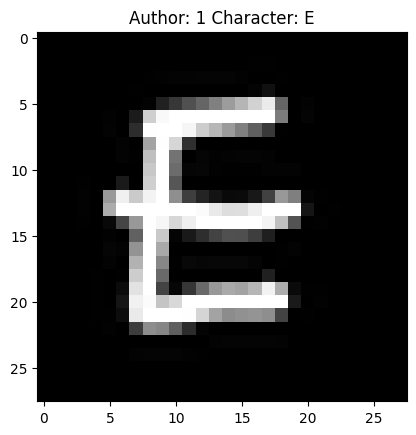

In [4]:
# View 1 Image
def process_image(path):

    img = Image.open(path)

    # Resize Image
    img = img.resize(size=(28, 28), resample=Image.ANTIALIAS)

    # Convert RGBA image to 4D array
    img_pixel = np.array(img)

    # Convert to grayscale -> MNIST format
    img_pixel = 255 - (img_pixel[:, :, :3] @ [0.299, 0.587, 0.114])

    return img_pixel

img_pixel = process_image('./HandwrittingAuthorIdentifier/Dataset/Author1/E4.png')

plt.title('Author: 1 Character: E')
plt.imshow(Image.fromarray(img_pixel))

In [3]:
# Create dataset
img_path = './HandwrittingAuthorIdentifier/Dataset'

data = []

for author_id, author_path in enumerate(os.listdir(img_path)):

    image_paths = os.listdir(f'{img_path}/{author_path}')

    for image_path in image_paths:

        img_pixel = process_image(f'{img_path}/{author_path}/{image_path}')

        row = np.append(img_pixel.flatten(), image_path[0])
        row = np.append(row, author_id)
        data.append(row)

# Dataframe creation
df = pd.DataFrame(data)
pixel_columns = [f'{i//28+1},{i%28+1}' for i in range(784)]
df.columns = pixel_columns + ['Character', 'Author'] # Pixel Row,Col from top left
df[pixel_columns] = df[pixel_columns].astype('float32')
df

1,1  1,2  1,3  1,4  1,5  1,6  1,7  1,8  1,9  1,10  ...  28,21  28,22  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  2.0   2.0  ...    0.0    0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  18.0  ...    0.0    0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...    ...   
715  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    2.0    0.0   
716  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   
717  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   
718  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   
719  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...    0.0    0.0   

     28,23  28,24  28,25  28,26  28,27  28,28  Character  Author  
0      0.0    0.0    0.0    0.0    0.0    0.0          R       0  
1      0.0    0.0    0.0    0.0    0.0    0.0          J       0  
2      0.0    0.0    0.0    0.0    0.0    0.0          7       0  
3      0.0    0.0    0.0    0.0    0.0    0.0          4       0  
4      0.0    0.0    0.0    0.0    0.0    0.0          B       0  
..     ...    ...    ...    ...    ...    ...        ...     ...  
715    0.0    0.0    0.0    0.0    0.0    0.0          K       4  
716    0.0    0.0    0.0    0.0    0.0    0.0          O       4  
717    0.0    0.0    0.0    0.0    0.0    0.0          U       4  
718    0.0    0.0    0.0    0.0    0.0    0.0          1       4  
719    0.0    0.0    0.0    0.0    0.0    0.0          7       4  

[720 rows x 786 columns]

## Alphanumeric Identifier

In [111]:
X = df.copy()
_ = X.pop('Author')
y = X.pop('Character')

# Reshape flatten pixels
X_reshaped = X.values.reshape(-1, 28, 28, 1)
print(X_reshaped.shape)

# Label Classes -> convert A to 10, B to 11, ...
y = y.apply(lambda x: int(x) if x.isnumeric() else ord(x) - 55)
y_cat = tf.keras.utils.to_categorical(y)

(720, 28, 28, 1)


CNN Hyperparameter Tuning Reference: https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [112]:
# Hyperparam Tuning
def fitness_evaluation(chromosome):

    conv2d_1 = chromosome[0]
    conv2d_2 = chromosome[1]
    dense_1 = chromosome[2]
    dropout_1 = chromosome[3]
    dropout_2 = chromosome[4]
    dropout_3 = chromosome[5]

    model = Sequential([

        layers.Rescaling(scale=1./255),

        layers.Conv2D(2**conv2d_1, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.Conv2D(2**conv2d_1, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(3, 3)),
        layers.Dropout(rate=dropout_1),

        layers.Conv2D(2**conv2d_2, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(2**conv2d_2, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(3, 3)),
        layers.Dropout(rate=dropout_2),

        layers.Flatten(),
        layers.Dense(dense_1, activation='relu'),
        layers.Dropout(rate=dropout_3),
        layers.Dense(36, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model.fit(X_reshaped, y_cat, epochs=15, verbose=0)

    return -max(history.history['categorical_accuracy'])

# Chromosome Genes: [conv2d_1 (2^), conv2d_2 (2^), dense_1, dropout_1, dropout_2, dropout_3]
varbound = np.array([[5, 7], [5, 7], [150, 160]] + [[0.2, 0.5]] * 3)
vartype = np.array([['int']] * 3 + [['real']] * 3)

### Genetic Algorithm Testing

In [114]:
# Standard Selection, Uniform Crossover
strategy_1 = {
    'max_num_iteration': 20,
    'population_size': 10,
    'mutation_probability': 0.2,
    'elit_ratio': 0,
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type':'uniform',
    'max_iteration_without_improv': None
}

ga_1 = GeneticAlgorithm(function=fitness_evaluation,
                        dimension=6,
                        variable_type_mixed=vartype,
                        variable_boundaries=varbound,
                        algorithm_parameters=strategy_1,
                        function_timeout=600,
                        convergence_curve=False)

ga_1.run()

 The best solution found:
 [  7.           7.         156.           0.28651838   0.28877545
   0.20572967]

 Objective function:
 -0.9652777910232544


In [115]:
    # Elitism Selection, Two Point Crossover
    strategy_2 = {
        'max_num_iteration': 20,
        'population_size': 10,
        'mutation_probability': 0.2,
        'elit_ratio': 0.01,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type':'two_point',
        'max_iteration_without_improv': None
    }

    ga_2 = GeneticAlgorithm(function=fitness_evaluation,
                            dimension=6,
                            variable_type_mixed=vartype,
                            variable_boundaries=varbound,
                            algorithm_parameters=strategy_2,
                            function_timeout=600,
                            convergence_curve=False)

    ga_2.run()

 The best solution found:
 [  7.           6.         152.           0.25363401   0.26354555
   0.29252049]

 Objective function:
 -0.949999988079071


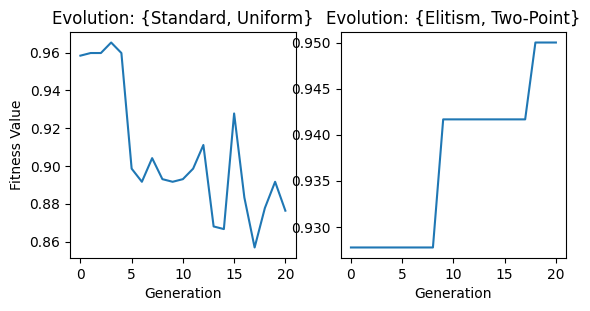

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# Evolution GA 1
ga_1_fitness_scores = list(map(lambda x: -x, ga_1.report))
ax1.plot(ga_1_fitness_scores)
ax1.set_box_aspect(1)
ax1.set_title('Evolution: {Standard, Uniform}')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness Value')

# Evolution GA 2
ga_2_fitness_scores = list(map(lambda x: -x, ga_2.report))
ax2.plot(ga_2_fitness_scores)
ax2.set_box_aspect(1)
ax2.set_title('Evolution: {Elitism, Two-Point}')
ax2.set_xlabel('Generation')

plt.show()

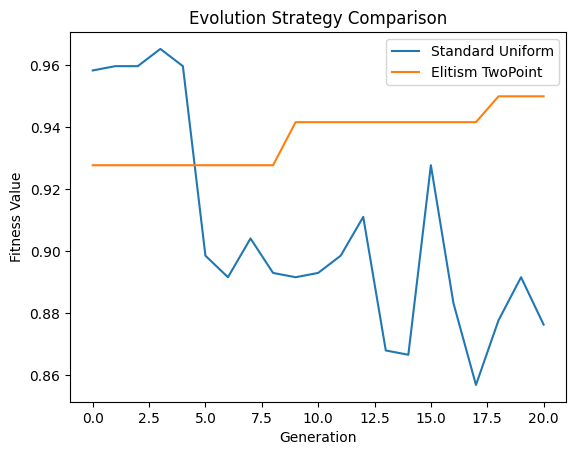

In [117]:
# Direct Comparison
plt.plot(ga_1_fitness_scores, label='Standard Uniform')
plt.plot(ga_2_fitness_scores, label='Elitism TwoPoint')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Evolution Strategy Comparison')
plt.legend()
plt.show()

In [118]:
# Best params
print(ga_1.output_dict)
print(ga_2.output_dict)

{'variable': array([  7.        ,   7.        , 156.        ,   0.28651838,
         0.28877545,   0.20572967]), 'function': -0.9652777910232544}
{'variable': array([  7.        ,   6.        , 152.        ,   0.25363401,
         0.26354555,   0.29252049]), 'function': -0.949999988079071}


This means that the best configuration for the simple CNN Architecture is:

- 1st Block: 2 layers of **2^7 = 128** kernels-Conv2d, dropout rate = 0.29
- 2nd Block: 2 layers of **2^7 = 128** kernels-Conv2d, dropout rate = 0.29
- 3rd Block: 1 flatten layer, 1 fully-connected layer of **156** neurons, dropout rate = 0.21
- 4th Block: output layer of 36 neurons

### Neural Network Testing

*Explanation* Reference: https://stackoverflow.com/questions/46515248/intuition-behind-stacking-multiple-conv2d-layers-before-dropout-in-cnn

In [119]:
# Simple CNN
model1 = Sequential([

    layers.Rescaling(scale=1./255),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(3, 3)),
    layers.Dropout(rate=0.29),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(3, 3)),
    layers.Dropout(rate=0.29),

    layers.Flatten(),
    layers.Dense(156, activation='relu'),
    layers.Dropout(rate=0.21),
    layers.Dense(36, activation='softmax')
])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train
history1 = model1.fit(X_reshaped, y_cat, epochs=40)

Epoch 1/40
23/23 [==============================] - 14s 525ms/step - loss: 3.5826 - categorical_accuracy: 0.0278
Epoch 2/40
23/23 [==============================] - 12s 517ms/step - loss: 3.2989 - categorical_accuracy: 0.0889
Epoch 3/40
23/23 [==============================] - 13s 559ms/step - loss: 2.5869 - categorical_accuracy: 0.2528
Epoch 4/40
23/23 [==============================] - 13s 570ms/step - loss: 1.6572 - categorical_accuracy: 0.4861
Epoch 5/40
23/23 [==============================] - 13s 571ms/step - loss: 1.0127 - categorical_accuracy: 0.6708
Epoch 6/40
23/23 [==============================] - 13s 564ms/step - loss: 0.7990 - categorical_accuracy: 0.7444
Epoch 7/40
23/23 [==============================] - 13s 566ms/step - loss: 0.5952 - categorical_accuracy: 0.7861
Epoch 8/40
23/23 [==============================] - 13s 566ms/step - loss: 0.4060 - categorical_accuracy: 0.8681
Epoch 9/40
23/23 [==============================] - 13s 572ms/step - loss: 0.2592 - categorical_

In [120]:
model2 = Sequential([

    # Load the pre-trained ResNet50 model without top layers (i.e., excluding the classification head)
    ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(155, activation="relu"),
    layers.Dense(36, activation="softmax")
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train
history2 = model2.fit(
    tf.image.resize(np.repeat(X_reshaped, 3, axis=-1).astype('float32') / 255, [32, 32]),
    y_cat,
    epochs=40
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/40
23/23 [==============================] - 67s 2s/step - loss: 3.5038 - categorical_accuracy: 0.2208
Epoch 2/40
23/23 [==============================] - 47s 2s/step - loss: 2.0821 - categorical_accuracy: 0.4931
Epoch 3/40
23/23 [==============================] - 45s 2s/step - loss: 1.3466 - categorical_accuracy: 0.6611
Epoch 4/40
23/23 [==============================] - 45s 2s/step - loss: 0.8809 - categorical_accuracy: 0.7694
Epoch 5/40
23/23 [==============================] - 45s 2s/step - loss: 0.8240 - categorical_accuracy: 0.7958
Epoch 6/40
23/23 [==============================] - 46s 2s/step - loss: 0.5950 - categorical_accuracy: 0.8778
Epoch 7/40
23/23 [==============================] - 47s 2s/step - loss: 0.4634 - categorical_accuracy: 0.8903
Epoch 8/40
23/23 [==============================] - 45s 2s/step - loss: 0.8936 - categorical_accuracy: 0.8083
Epoch 9/40
23/23 [==============================] - 45s

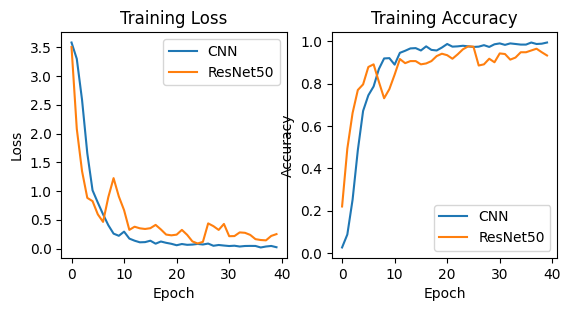

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# Training Loss
ax1.plot(history1.history['loss'], label='CNN')
ax1.plot(history2.history['loss'], label='ResNet50')
ax1.set_box_aspect(1)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Training Accuracy
ax2.plot(history1.history['categorical_accuracy'], label='CNN')
ax2.plot(history2.history['categorical_accuracy'], label='ResNet50')
ax2.set_box_aspect(1)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [125]:
print(f'''Highest Accuracy Achieved for CNN: {max(history1.history['categorical_accuracy'])}
Highest Accuracy Achieved for ResNet50: {max(history2.history['categorical_accuracy'])}''')

Highest Accuracy Achieved for CNN: 0.9930555820465088
Highest Accuracy Achieved for ResNet50: 0.9750000238418579


In [217]:
# Saving model
model1.save('best_model.h5')
model2.save('not_so_best_model.keras')

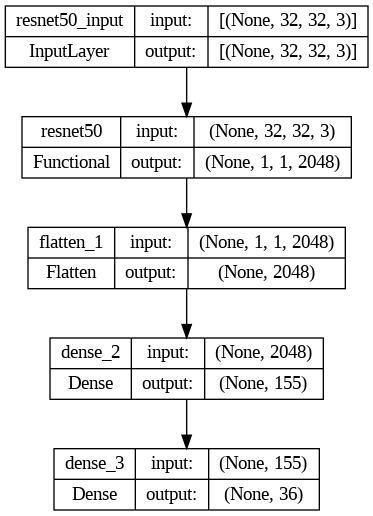

In [133]:
tf.keras.utils.plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

## Author Identification

In [5]:
def calculate_gradient(x1, y1, x2, y2):

    if x1 == x2 and y1 == y2: return 0
    if x1 == x2: return y2 - y1
    return (y2 - y1) / (x2 - x1)

def get_gradient(row):

    row = row.iloc[:-2]

    # Get significant bright pixels
    bright_pixels = row[row > 50]
    bright_pixels.name = 'brightness'
    bright_pixels = bright_pixels.reset_index()
    bright_pixels['i'] = bright_pixels['index'].str.split(',').str[0].astype(int)
    bright_pixels['j'] = bright_pixels['index'].str.split(',').str[1].astype(int)

    # Get 3 points
    bright_pixels = bright_pixels.sort_values(['i', 'brightness'], ascending=[True, False])
    top_i, top_j = bright_pixels.iloc[0][['i', 'j']].tolist()

    bright_pixels = bright_pixels.sort_values(['j', 'brightness'], ascending=[True, False])
    left_i, left_j = bright_pixels.iloc[0][['i', 'j']].tolist()

    bright_pixels = bright_pixels.sort_values(['j', 'brightness'], ascending=[False, False])
    right_i, right_j = bright_pixels.iloc[0][['i', 'j']].tolist()

    # Calculate gradients
    gradient_1 = calculate_gradient(left_i, left_j, top_i, top_j)
    gradient_2 = calculate_gradient(right_i, right_j, top_i, top_j)
    gradient_3 = calculate_gradient(left_i, left_j, right_i, right_j)

    return gradient_1, gradient_2, gradient_3

In [6]:
gradient_data = df.copy()
gradient_data[['gradient_1', 'gradient_2', 'gradient_3']] = gradient_data.apply(get_gradient, axis=1, result_type='expand')
gradient_data = gradient_data[['gradient_1', 'gradient_2', 'gradient_3', 'Character', 'Author']].sort_values(by=['Character', 'Author'])
gradient_data = gradient_data.reset_index(drop=True)
gradient_data

gradient_1  gradient_2  gradient_3 Character Author
0     -0.727273    0.666667   -2.400000         0      0
1     -0.692308    0.500000   -1.714286         0      0
2     -0.411765    0.333333   -6.000000         0      0
3     -0.388889    0.500000   -1.500000         0      0
4     -0.555556    0.750000  -11.000000         0      1
..          ...         ...         ...       ...    ...
715   -2.000000    1.272727    1.600000         Z      3
716   -0.785714    0.428571   -2.000000         Z      4
717   -0.133333    0.857143  -14.000000         Z      4
718   -0.428571    0.692308    2.000000         Z      4
719   -0.428571    0.538462  -13.000000         Z      4

[720 rows x 5 columns]

In [146]:
gradient_data.to_csv('gradient_data.csv', index=False)

In [7]:
!mkdir kde_output

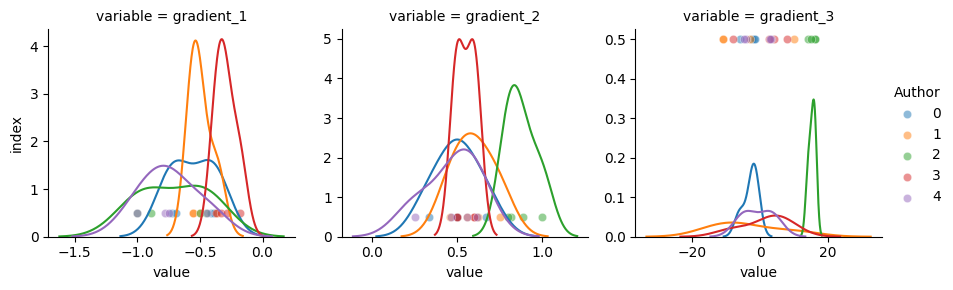

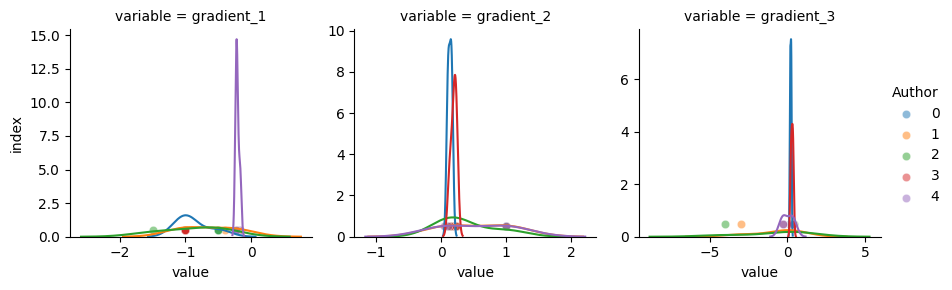

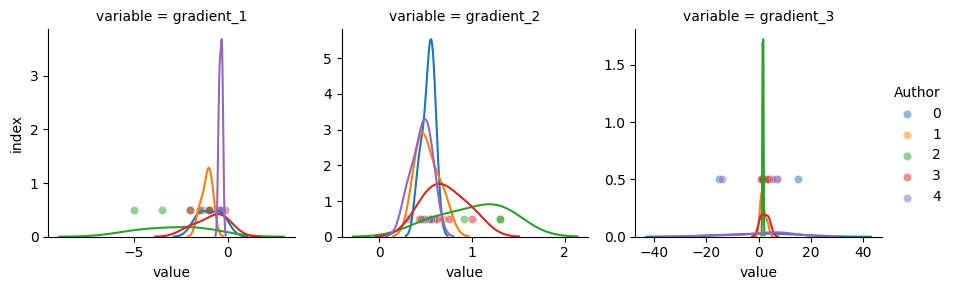

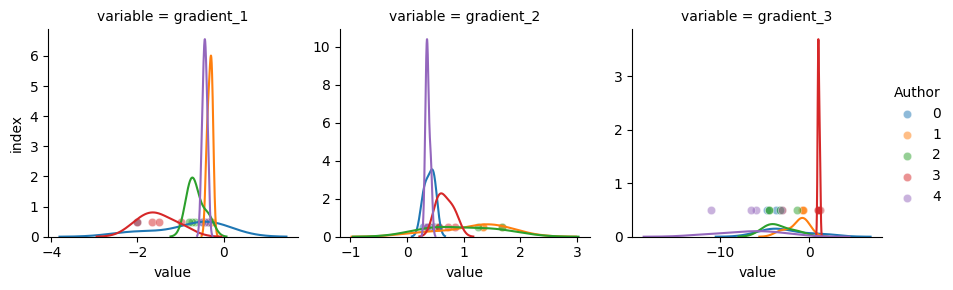

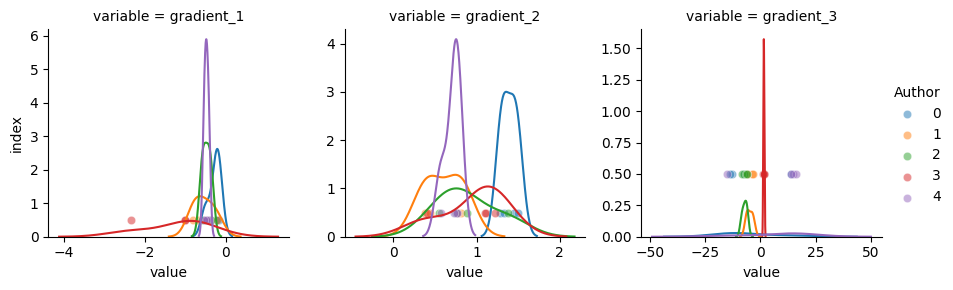

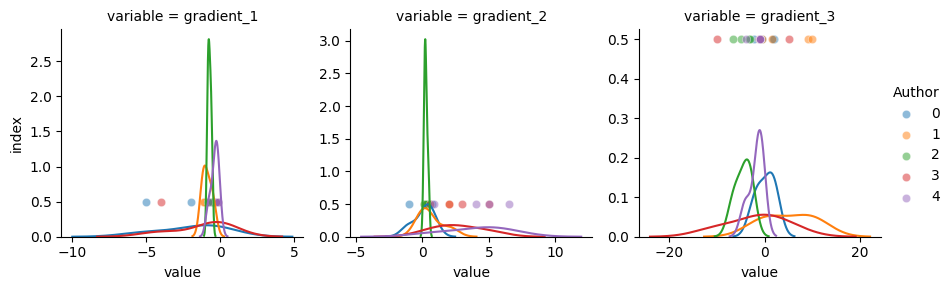

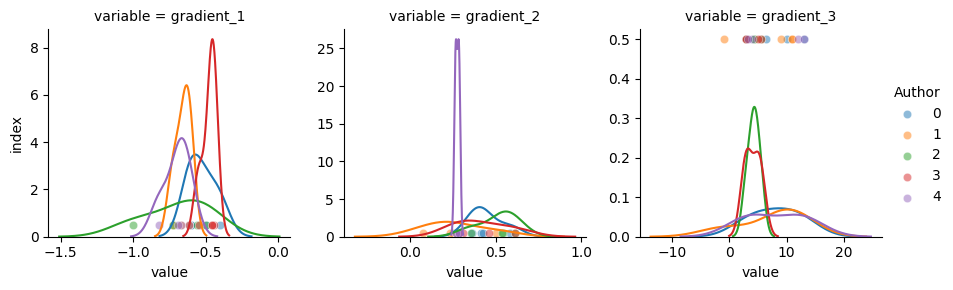

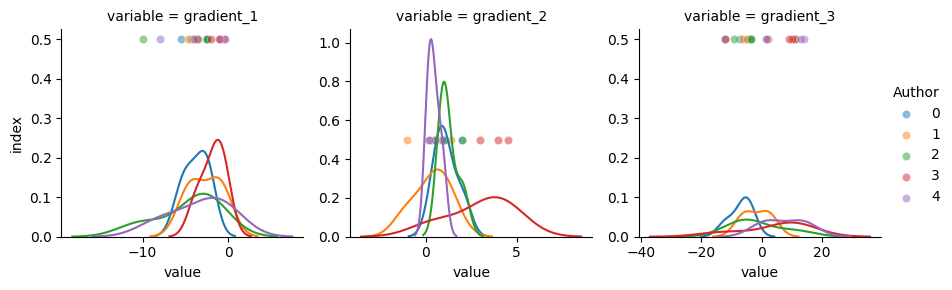

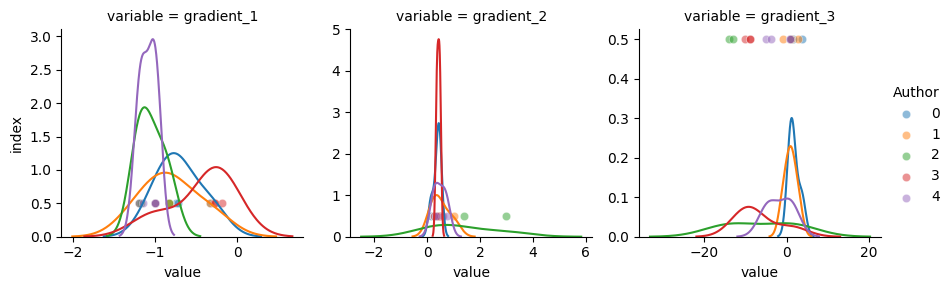

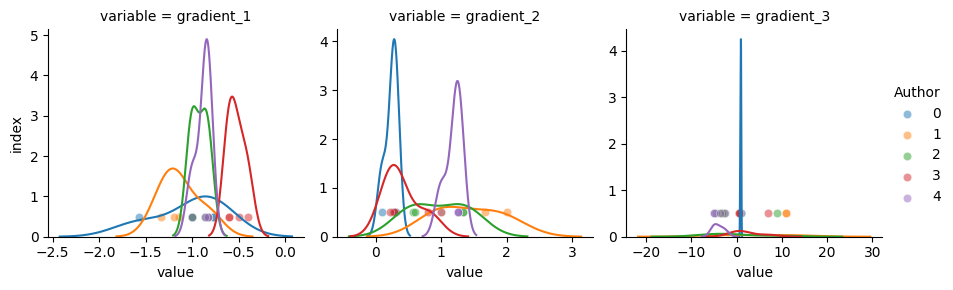

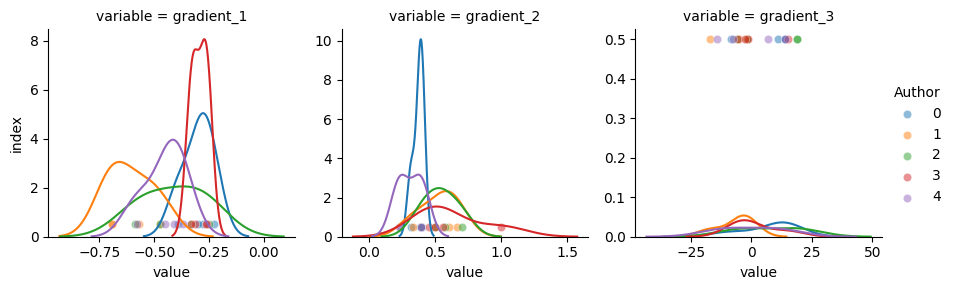

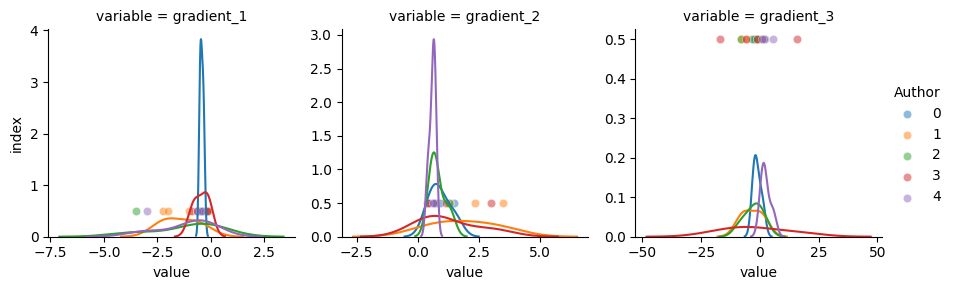

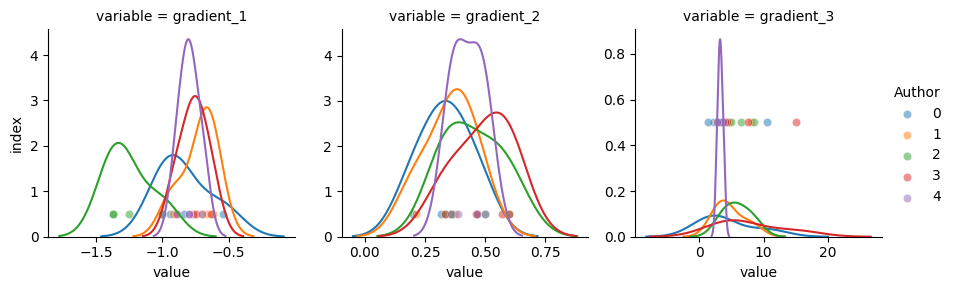

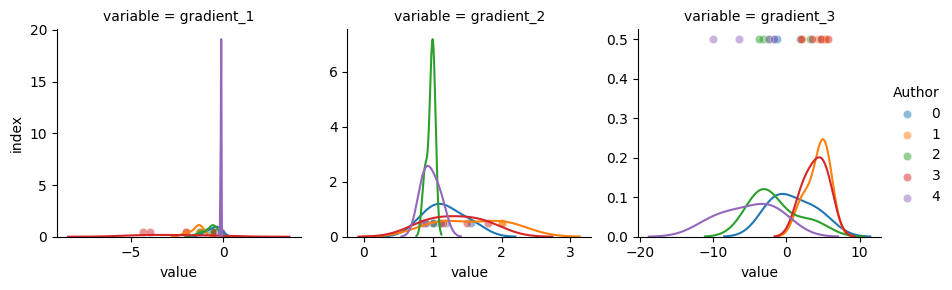

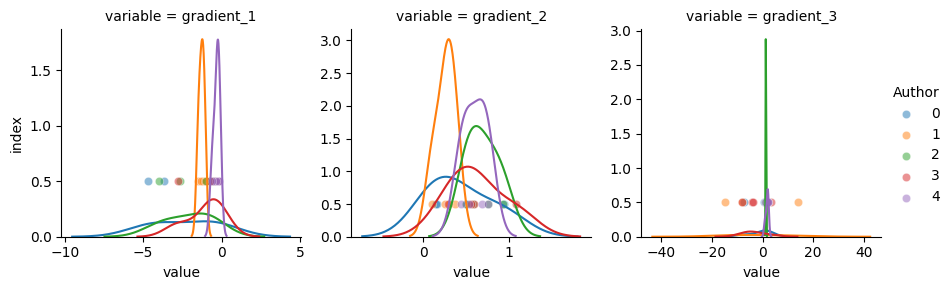

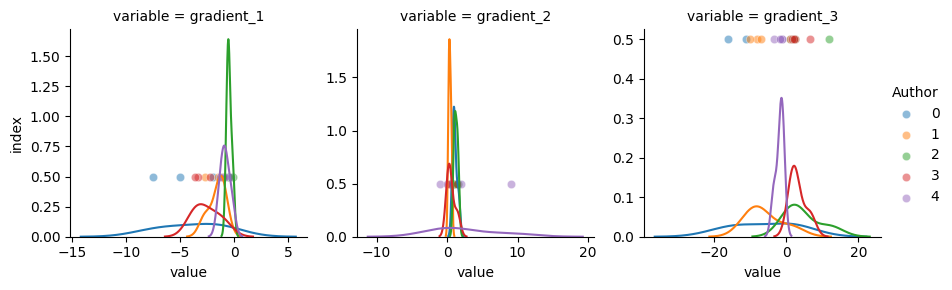

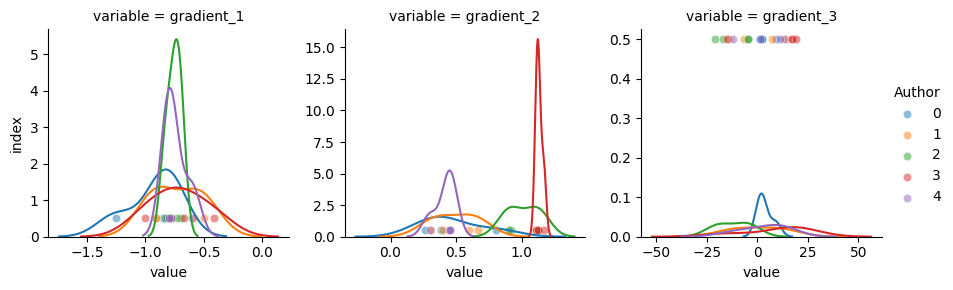

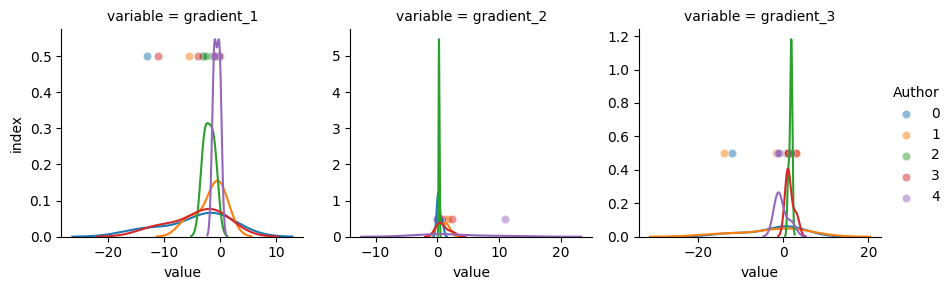

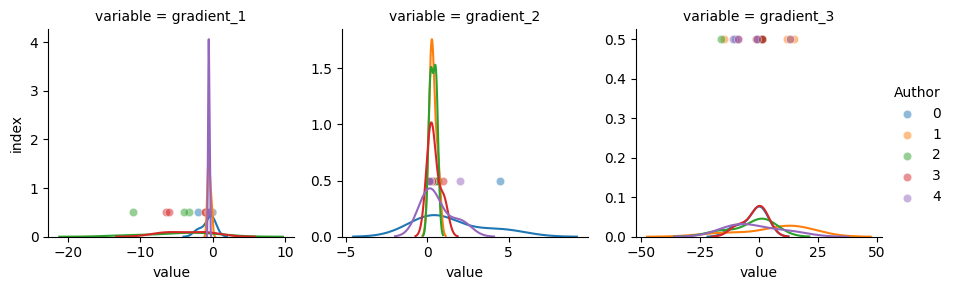

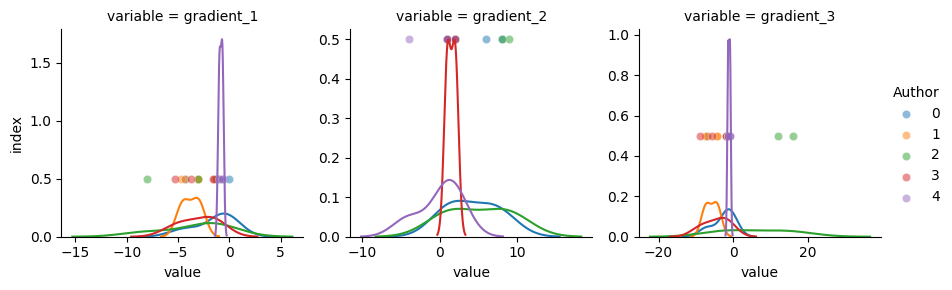

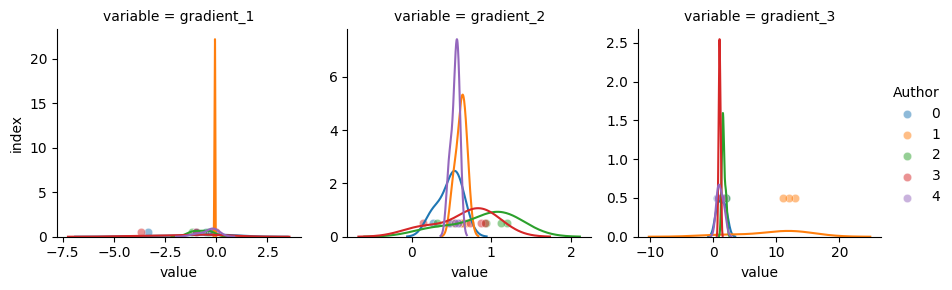

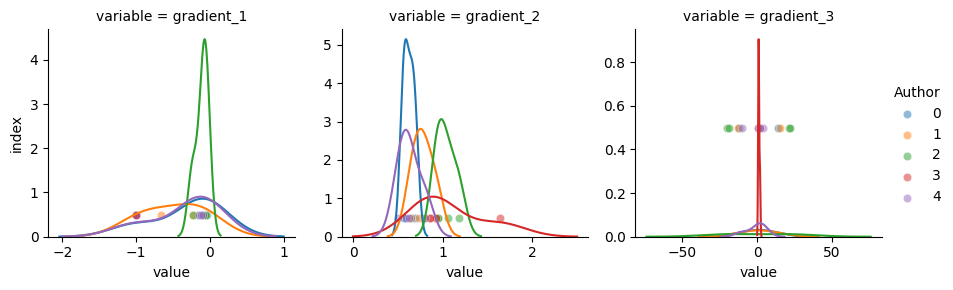

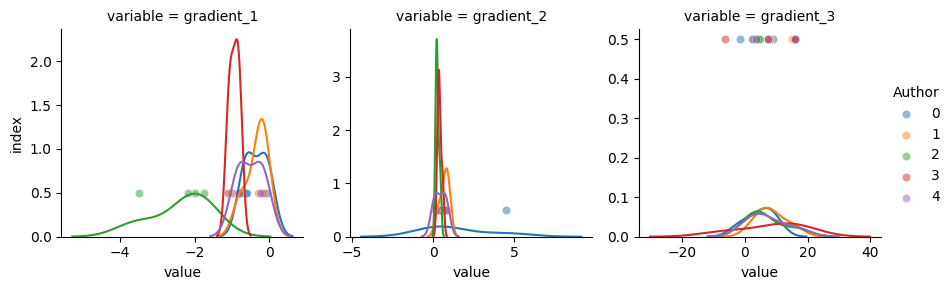

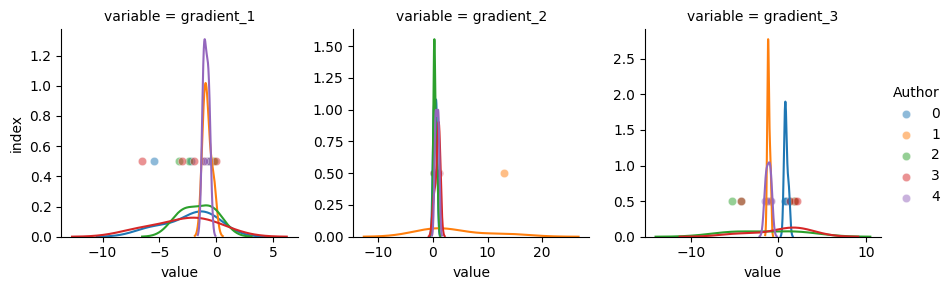

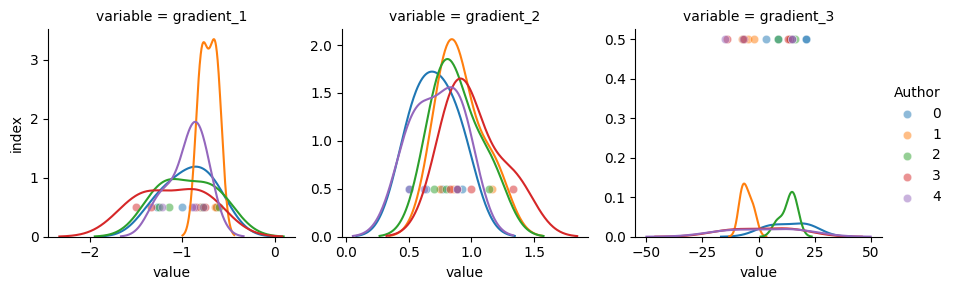

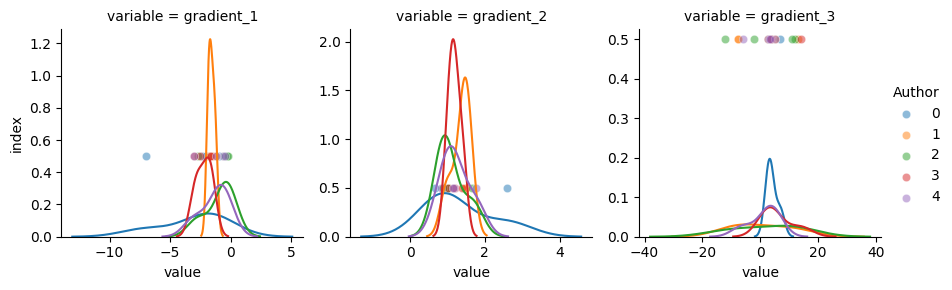

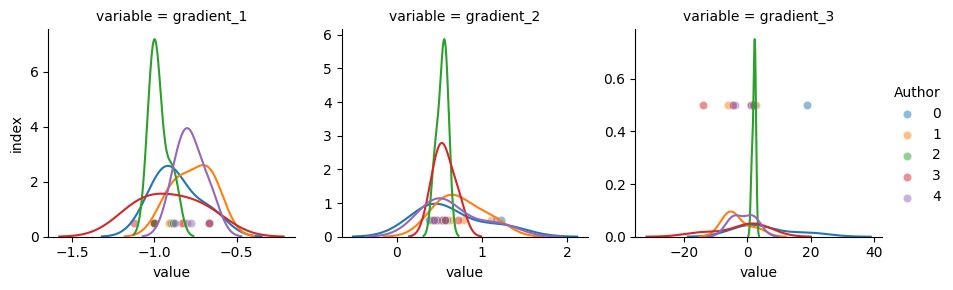

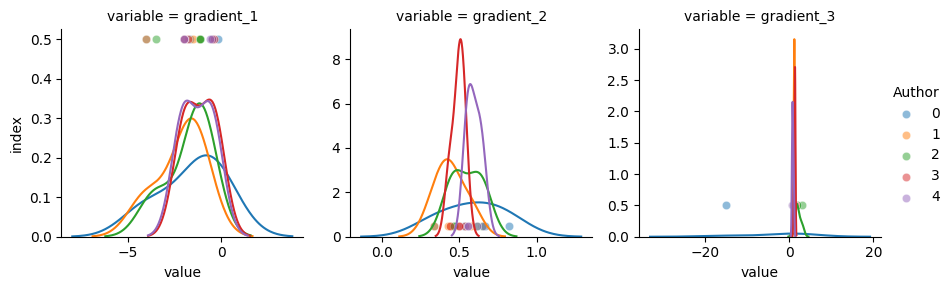

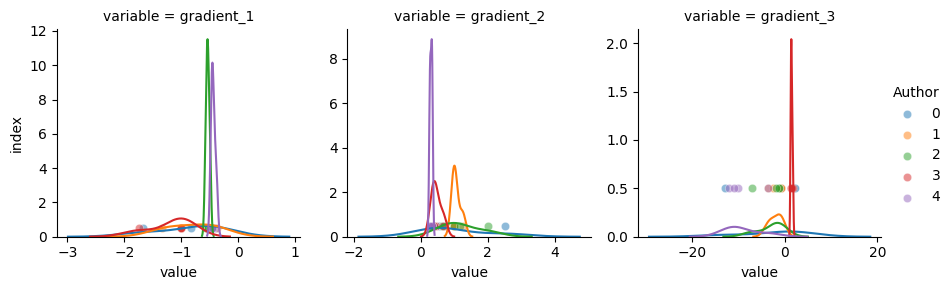

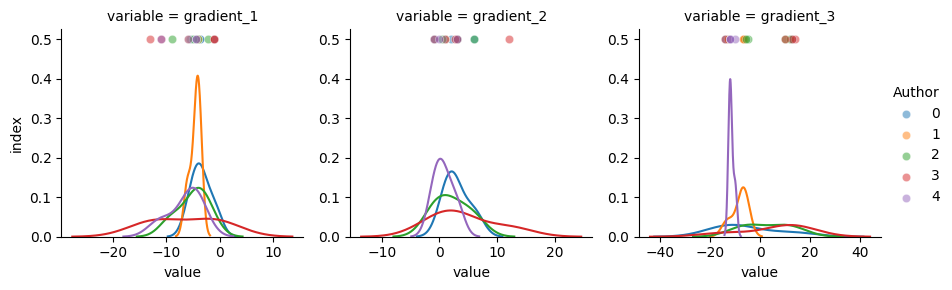

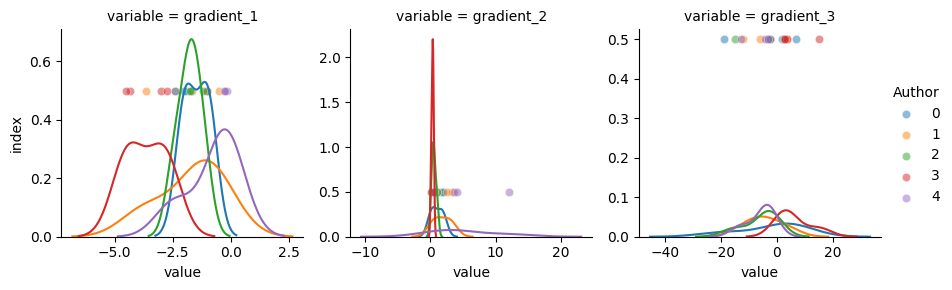

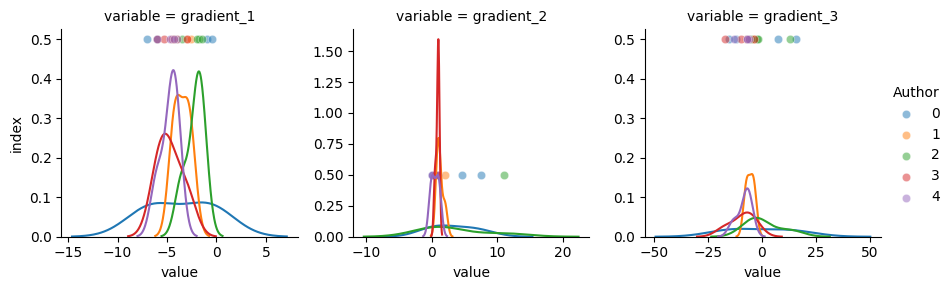

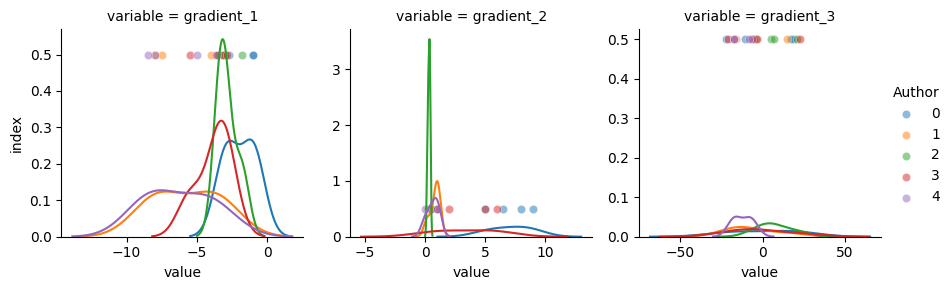

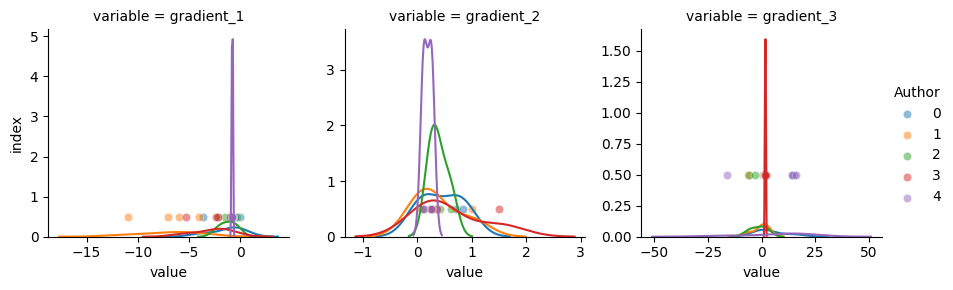

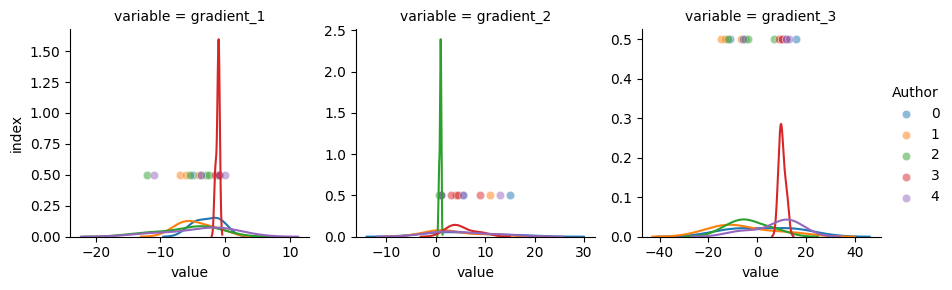

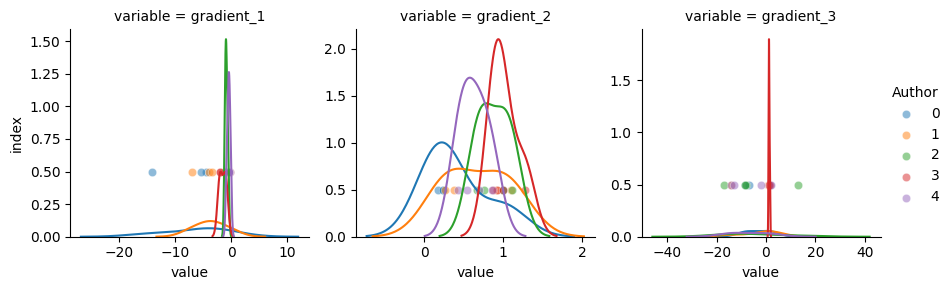

In [8]:
unique_char = gradient_data['Character'].unique()

for char in unique_char:

    char_data = gradient_data[gradient_data['Character'] == char][['Author', 'gradient_1', 'gradient_2', 'gradient_3']]
    char_data_melt = pd.melt(char_data, id_vars=['Author'], value_vars=['gradient_1', 'gradient_2', 'gradient_3'])
    char_data_melt['index'] = 0.5
    g = sns.FacetGrid(char_data_melt, col='variable', hue='Author', sharex=False, sharey=False)
    g.map(sns.kdeplot, 'value')
    g.map(sns.scatterplot, 'value', 'index', alpha=0.5)
    g.add_legend()
    g.savefig(f'kde_output/{char}-dist.jpg')

0 [2.1708868008178115, 4.375198503470909, 15.686440373292367, 0.007185445426842441, 0.0369783895098942]
1 [0.8901946727758834, 0.21280903160149223, 0.18351951404154376, 0.11142272036904398, 1.9162354068173393]
2 [6.1841375514031185, 1.477813746742025, 1.7745761304077319, 0.07728358508836784, 0.0054862231631962015]
3 [-5.78592497303347, 1.0287257920007458, -4.093904021252569, 0.07032149029505406, 0.030039887928926243]
4 [14.722533808792633, 1.5538305922317788, -6.7005065179163354, 0.04261595314739222, 0.00587437601074281]
5 [4.960682786738627, 2.1979707059002327, 0.21841711068438474, 0.08744842311680201, 0.0992992205402937]
6 [4.875184321334453, 3.3338838117341245, 4.411594523750397, 0.013792719138441456, 0.014397064259262085]
7 [2.98313322964062, 9.609532012281477, -5.0878281607690425, 0.01307684617893919, 0.019927661123376565]
8 [0.09503830777130595, -9.275299004457263, -0.6739154231478821, 0.04588558327066093, 0.06010032169739034]
9 [-4.611957153872595, 0.6232887211489873, -3.3661785

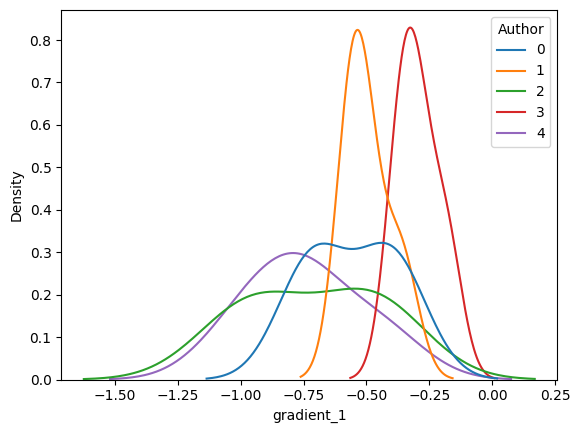

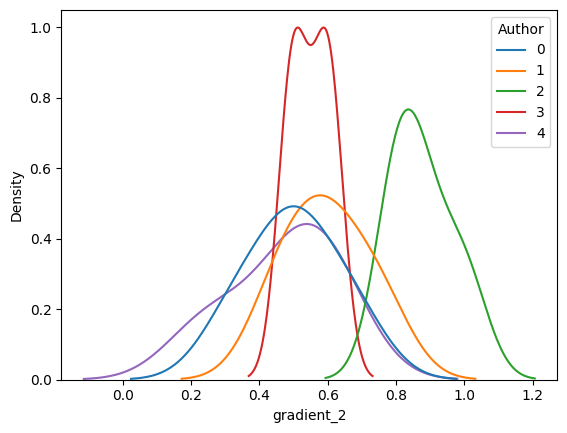

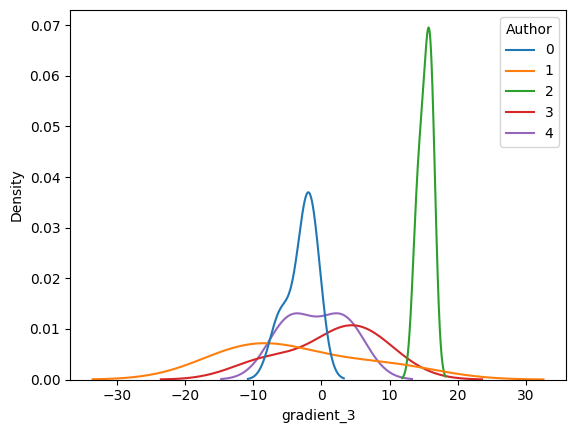

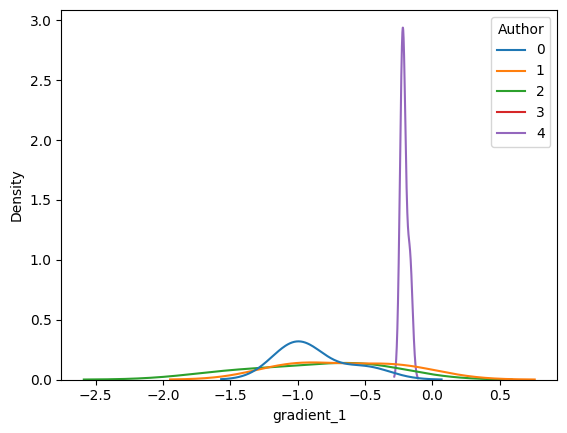

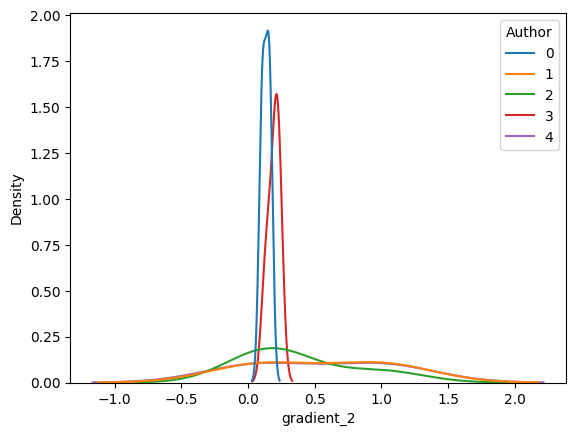

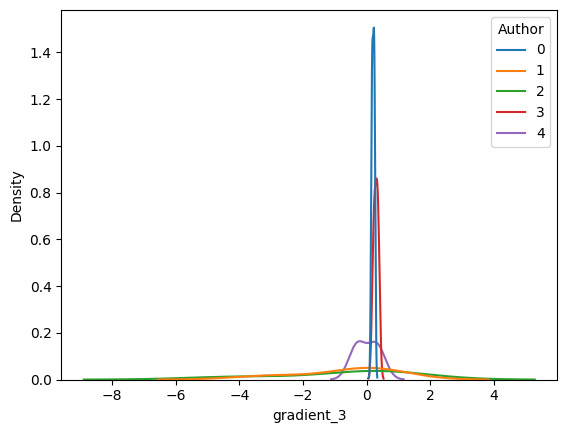

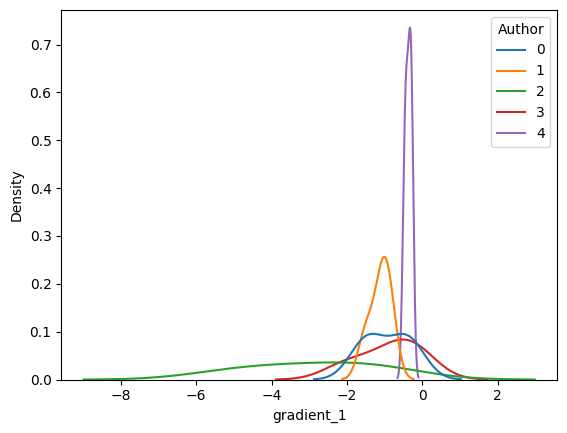

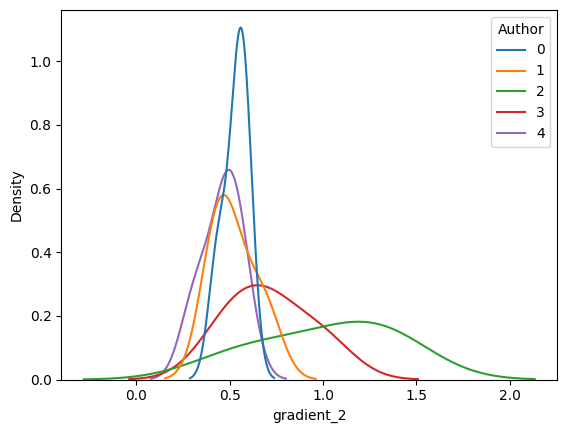

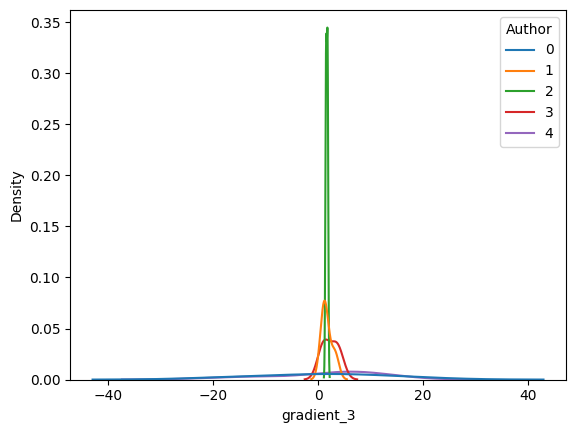

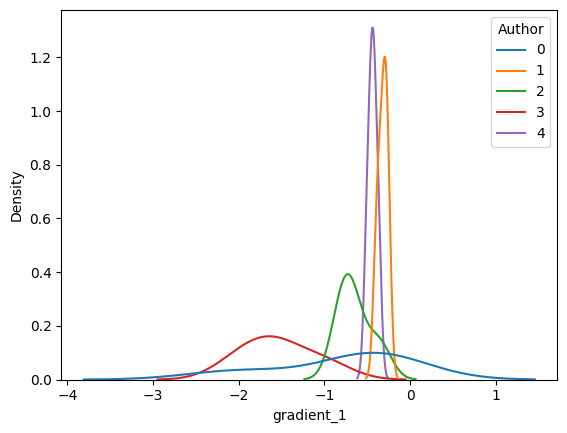

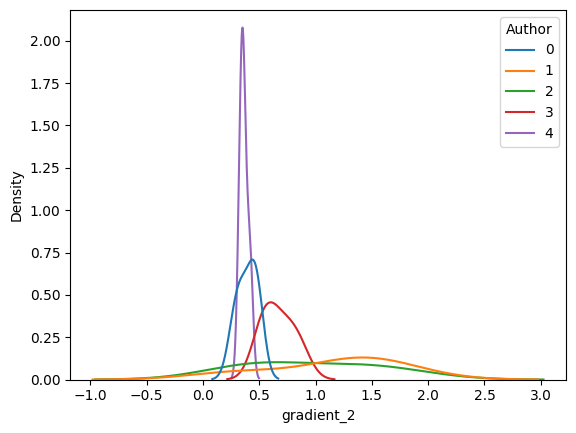

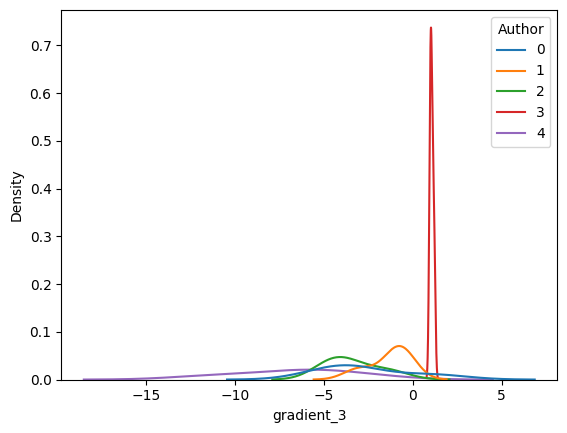

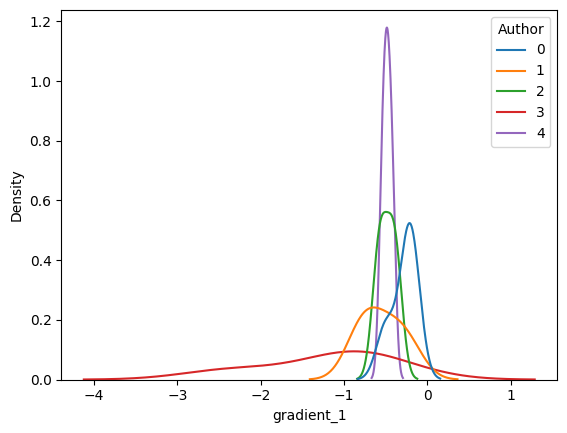

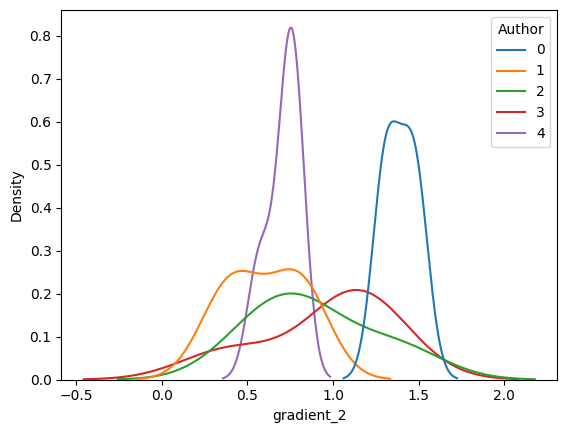

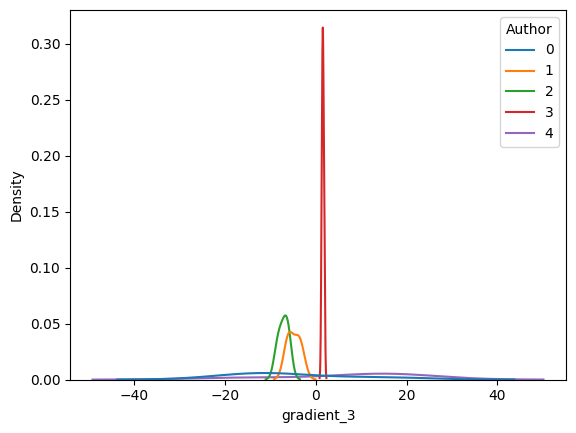

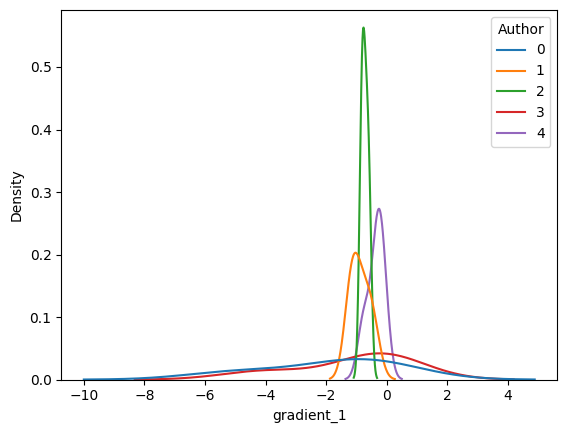

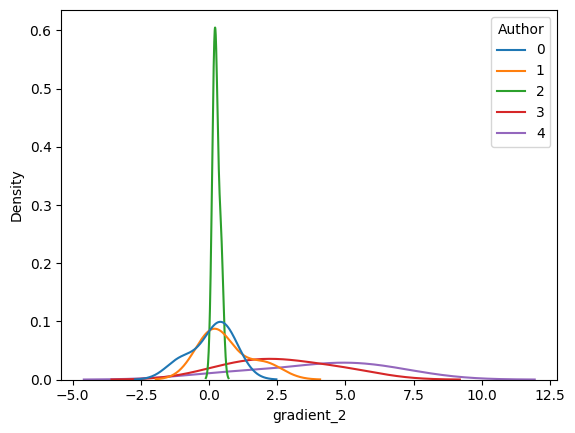

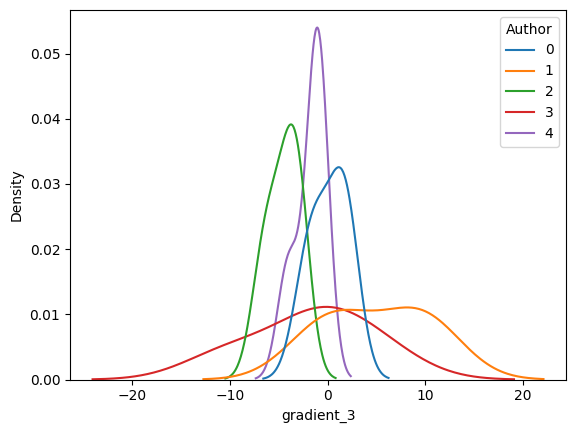

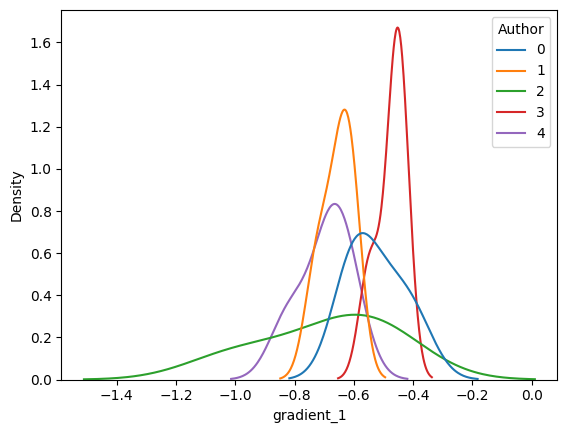

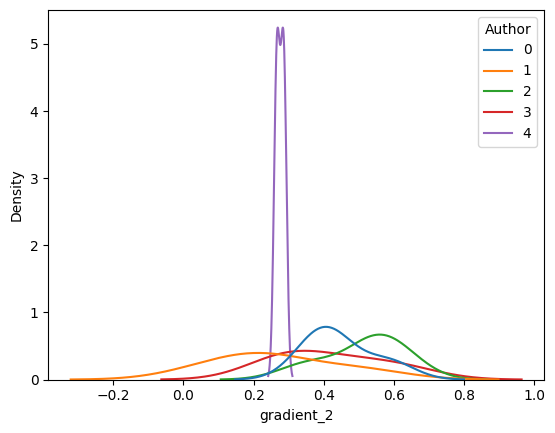

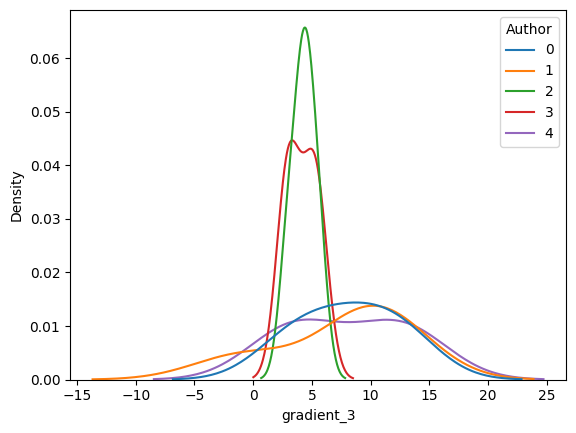

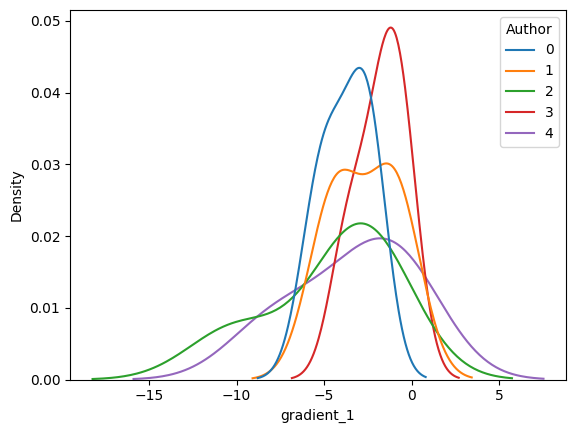

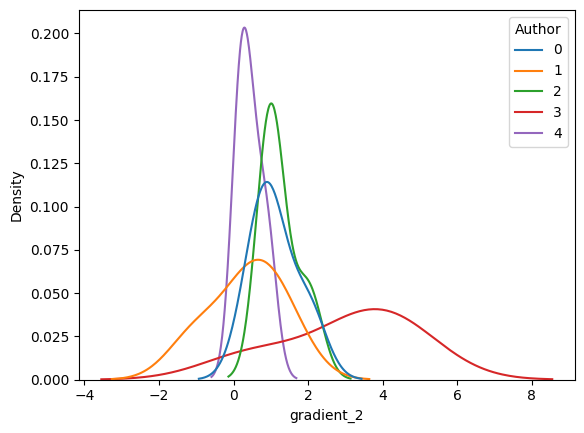

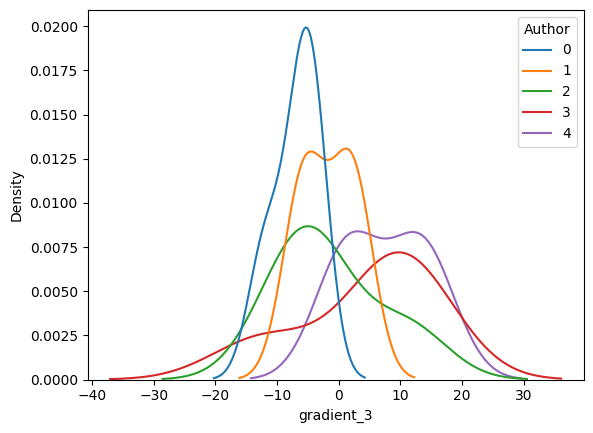

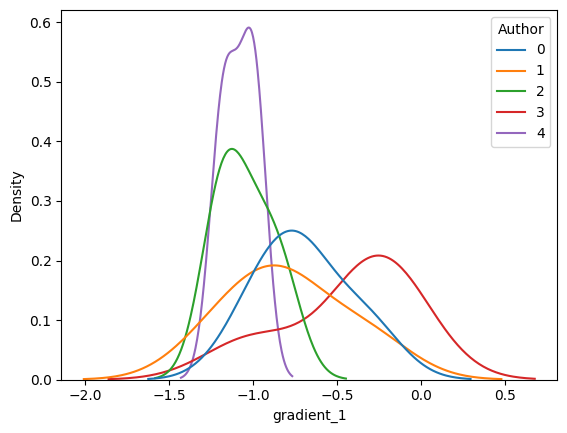

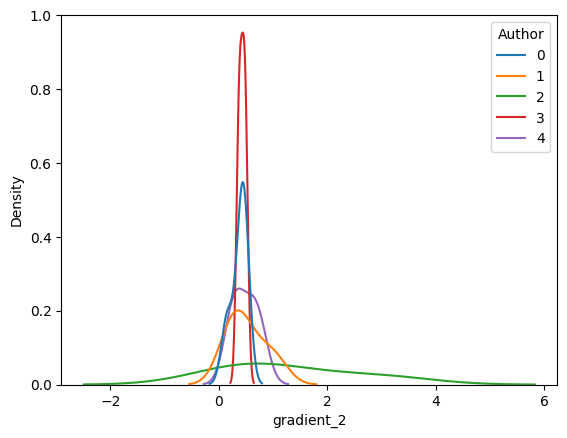

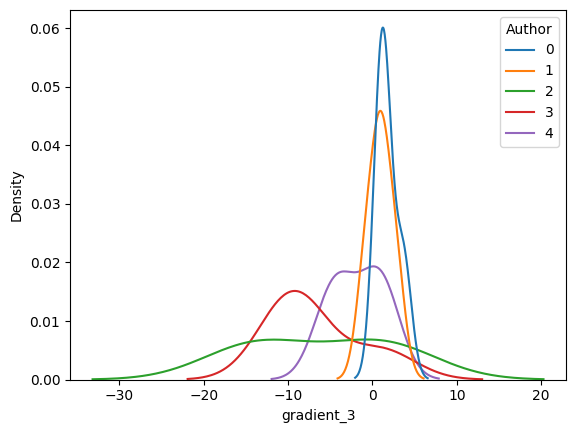

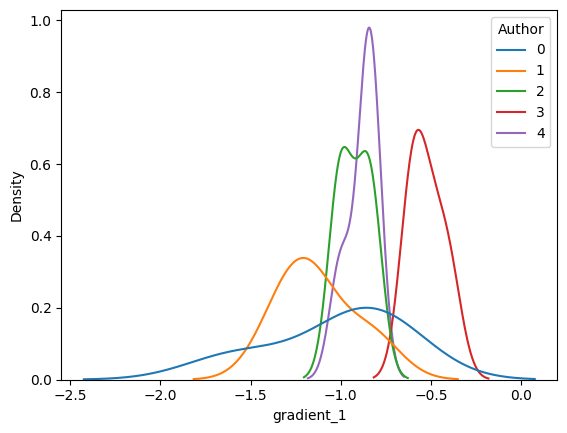

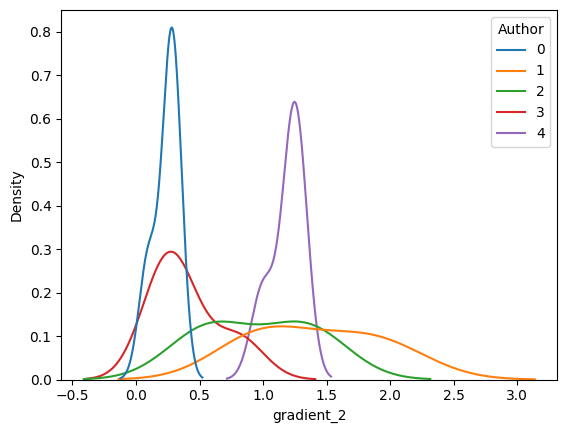

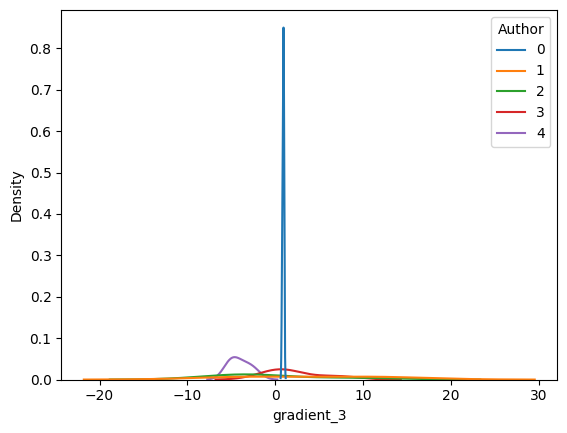

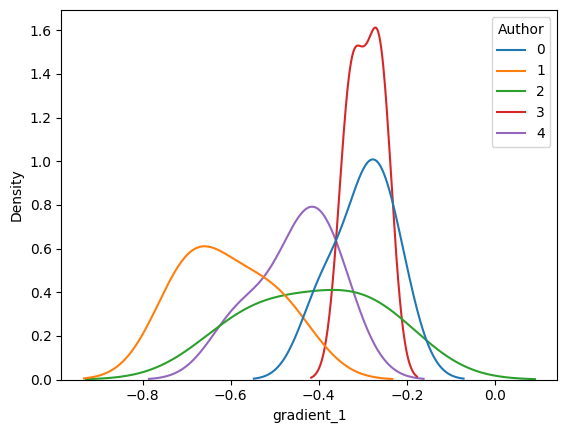

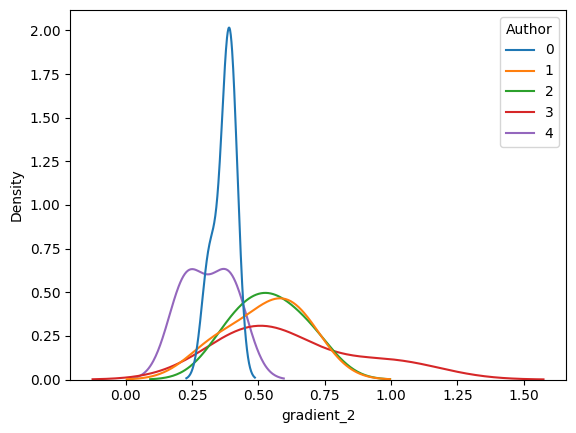

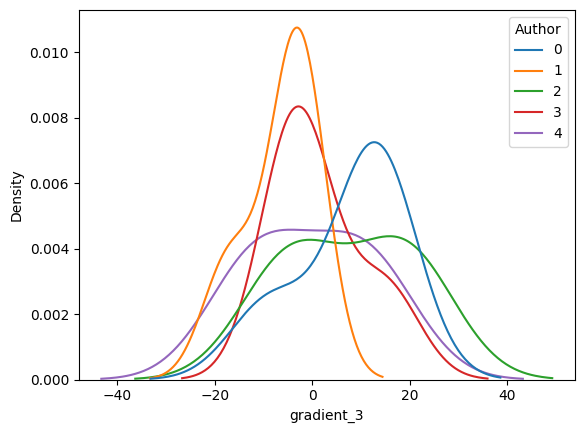

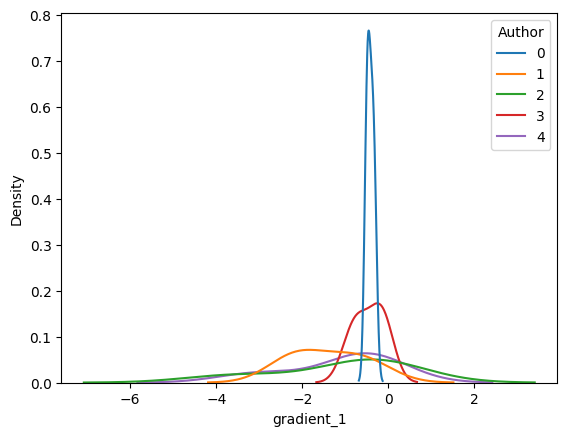

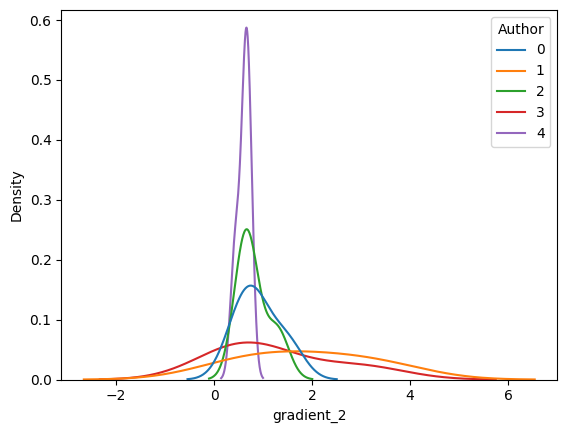

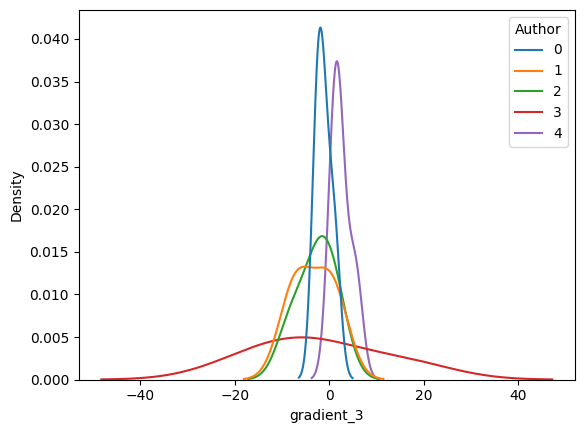

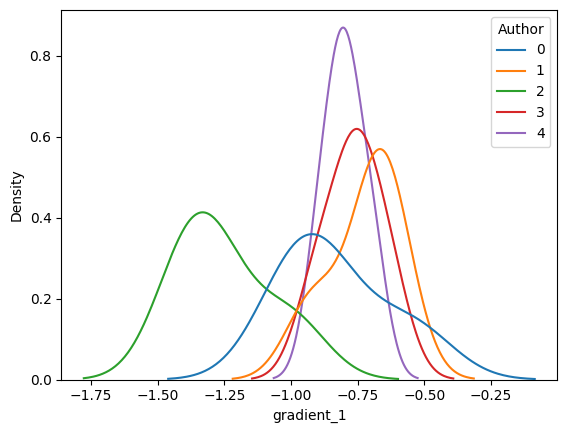

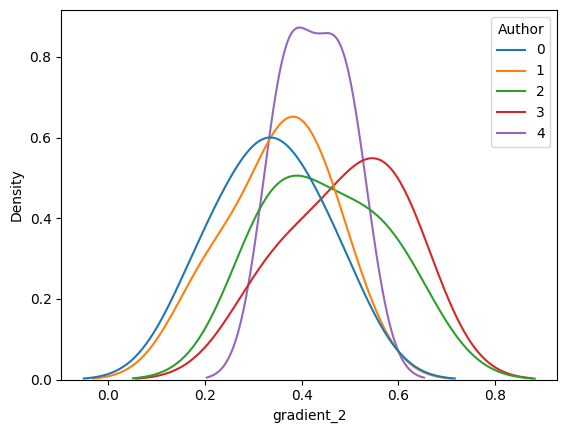

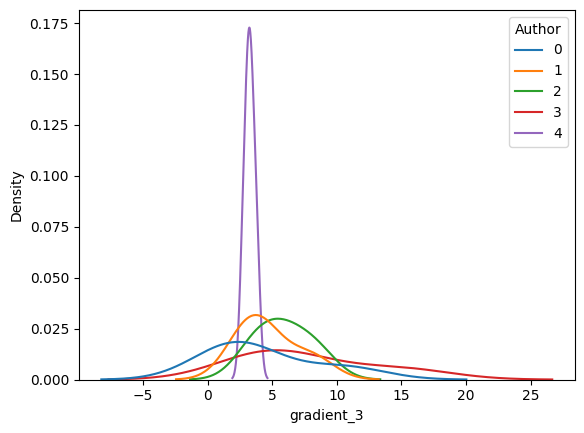

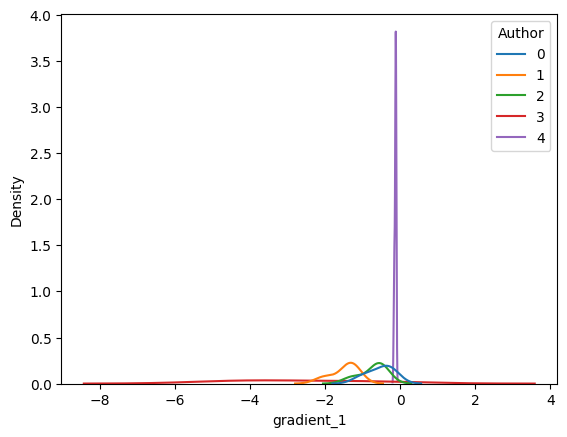

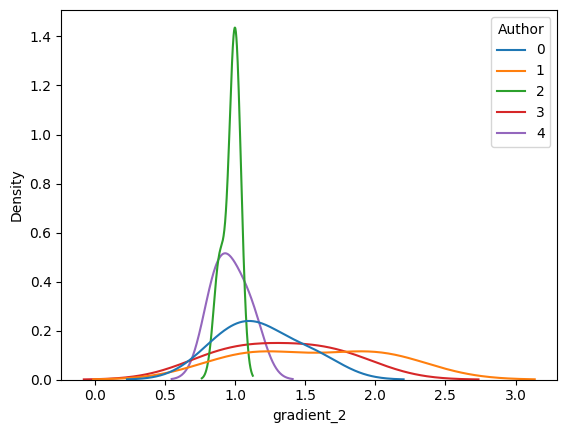

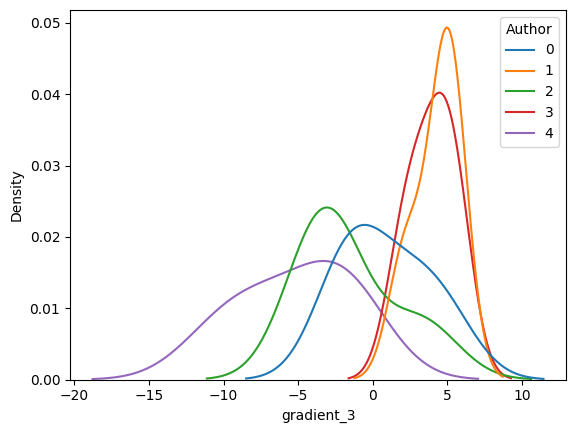

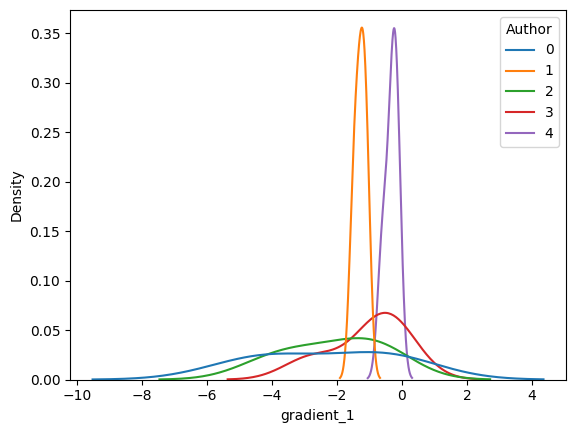

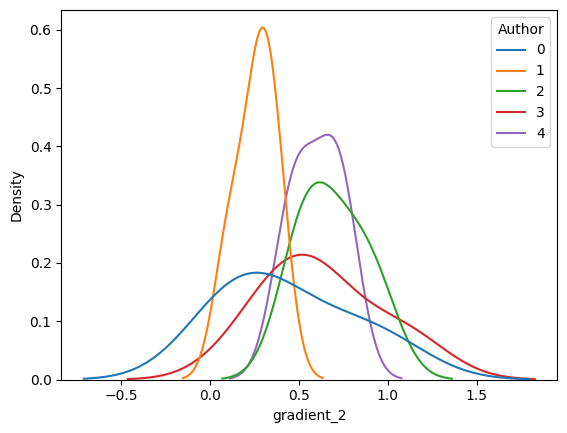

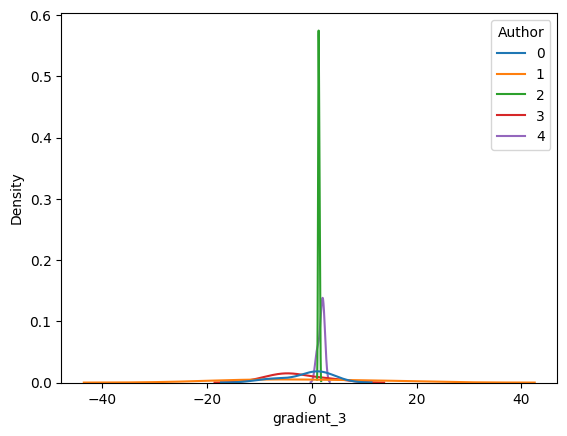

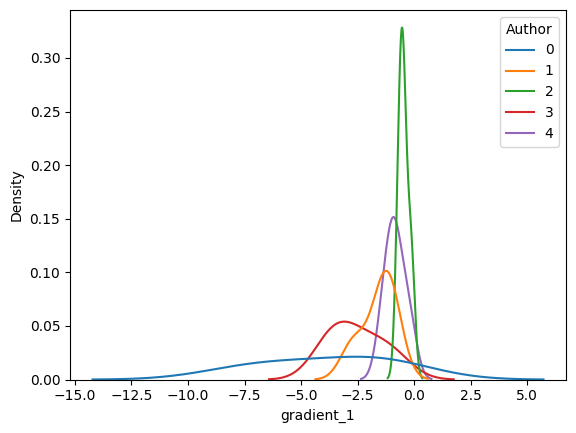

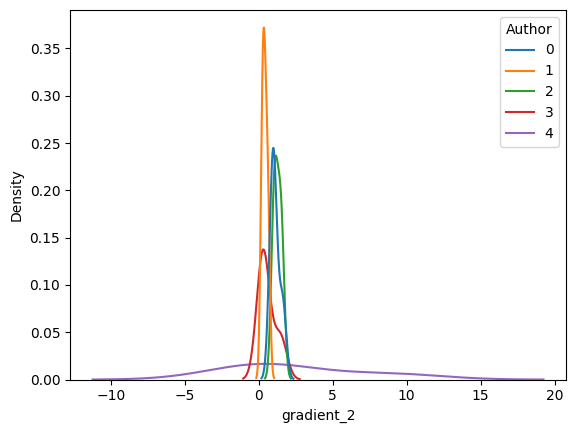

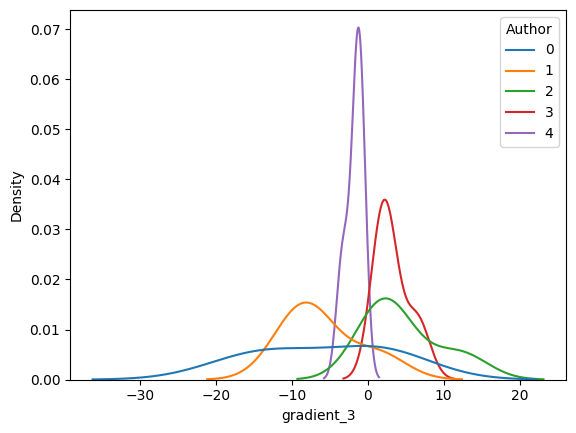

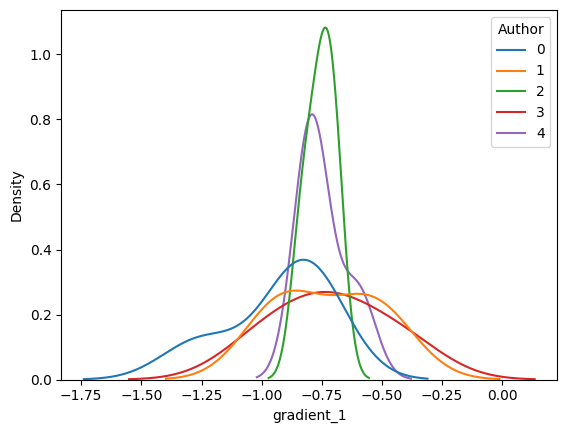

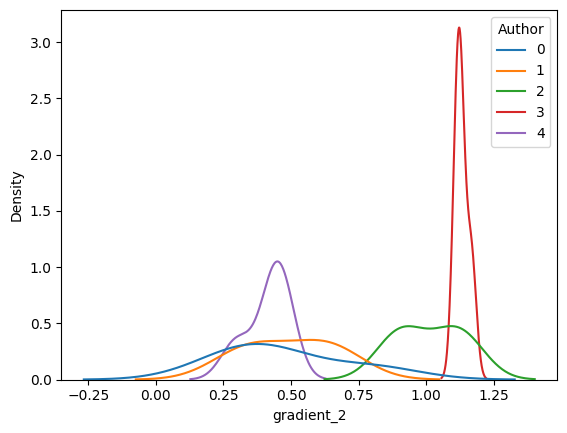

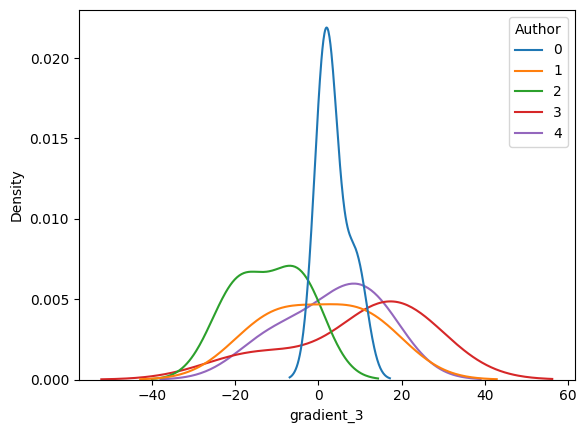

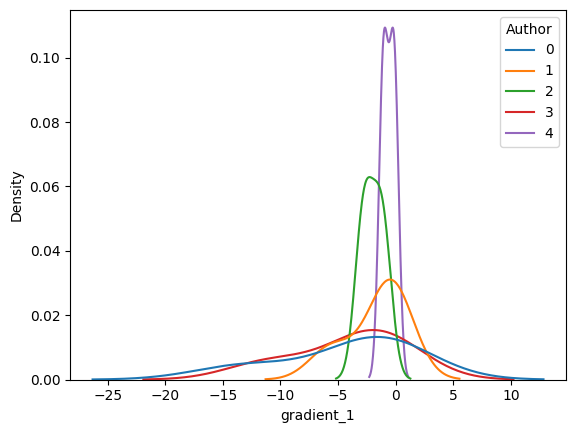

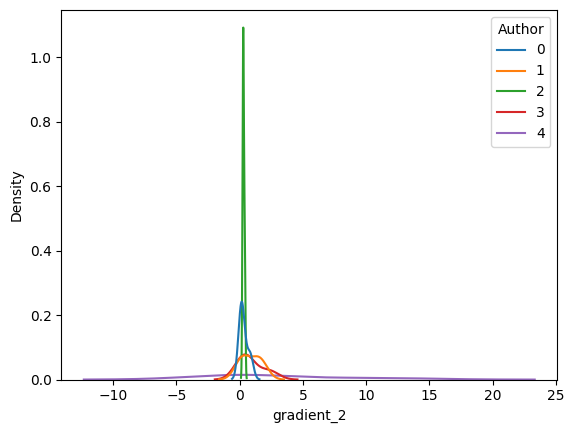

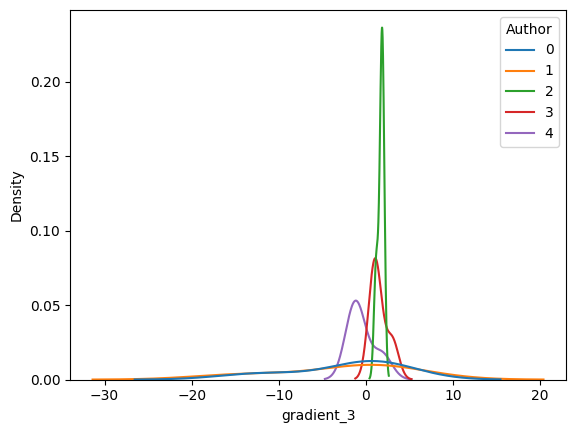

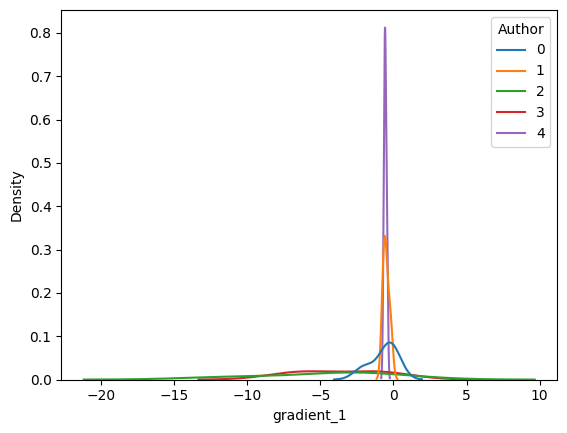

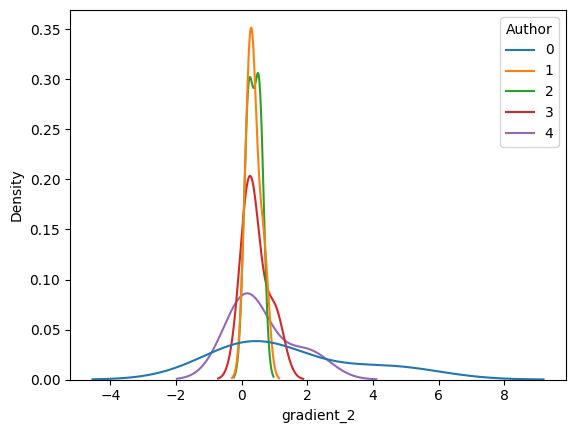

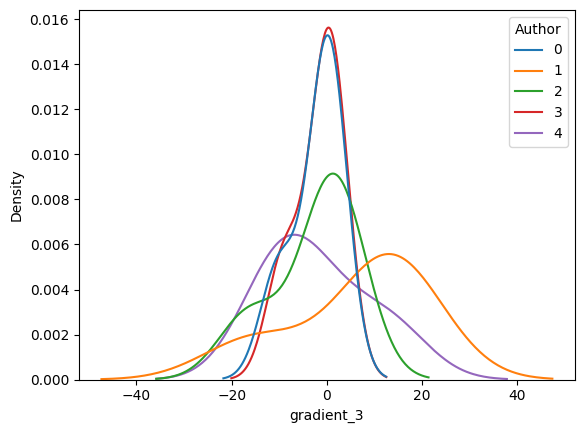

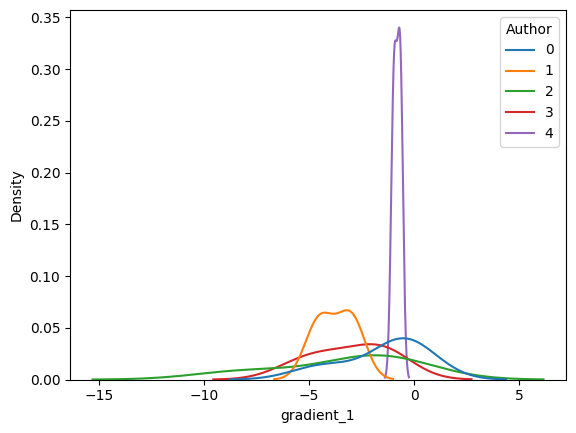

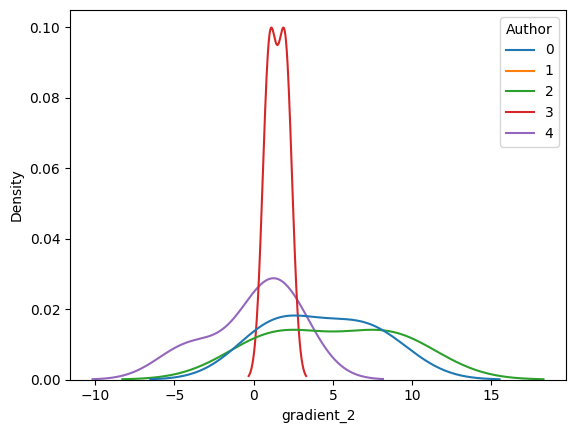

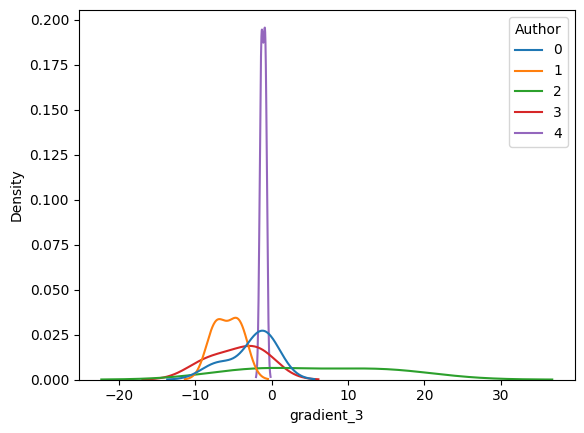

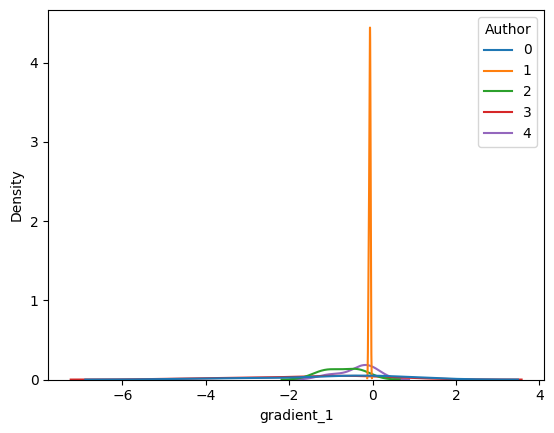

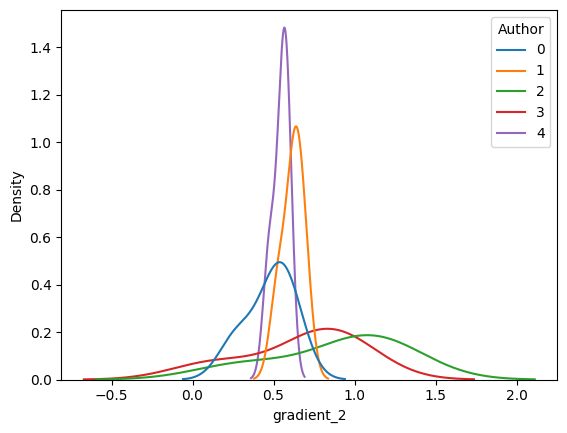

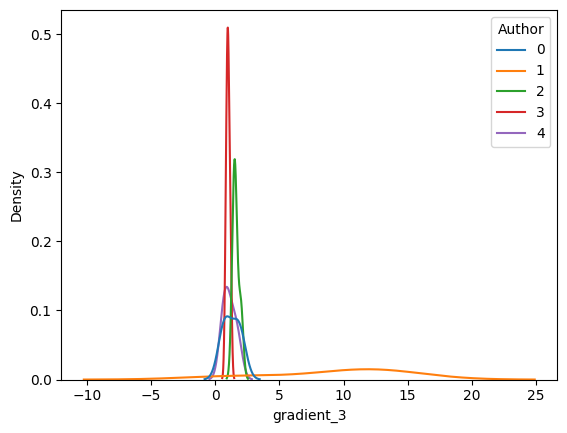

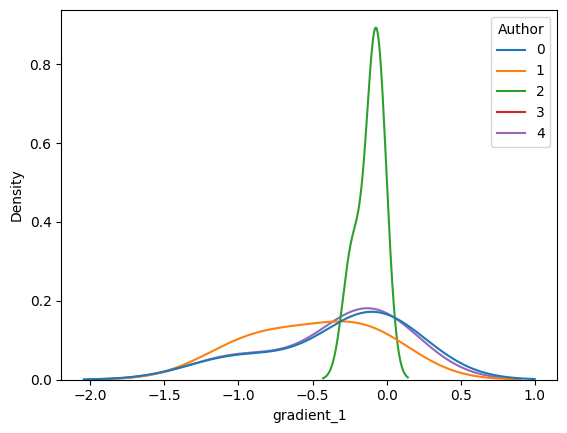

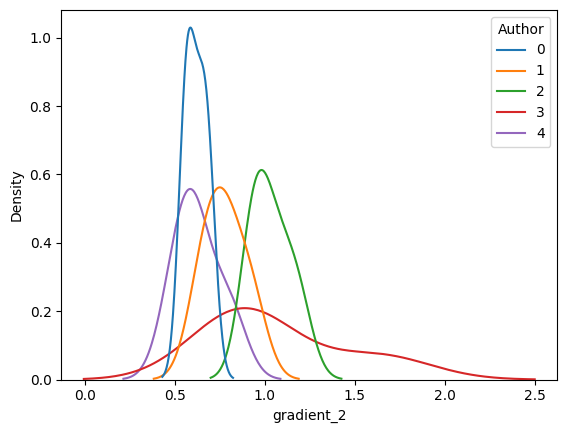

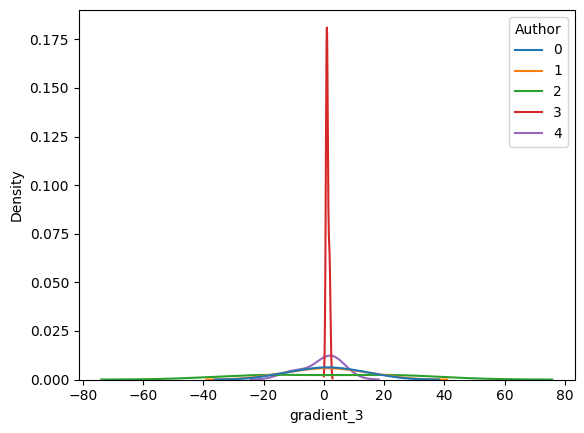

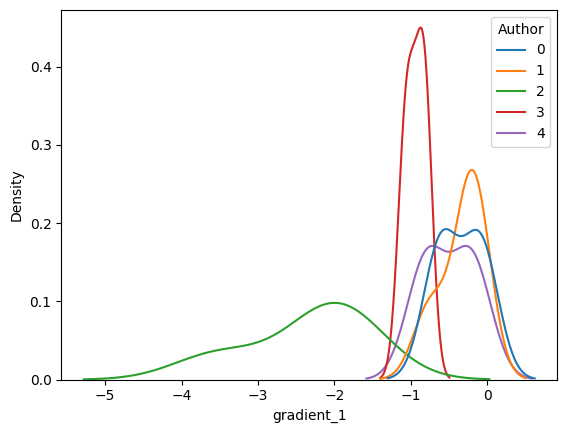

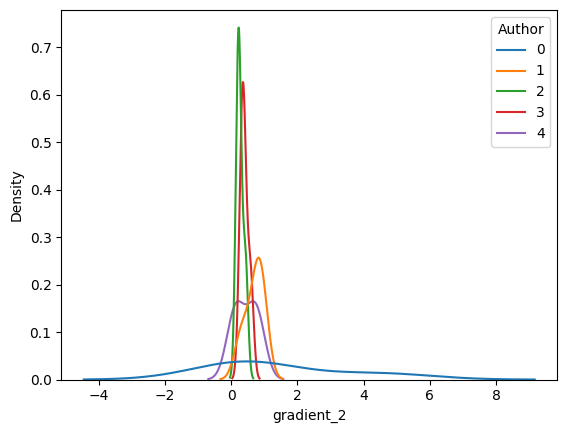

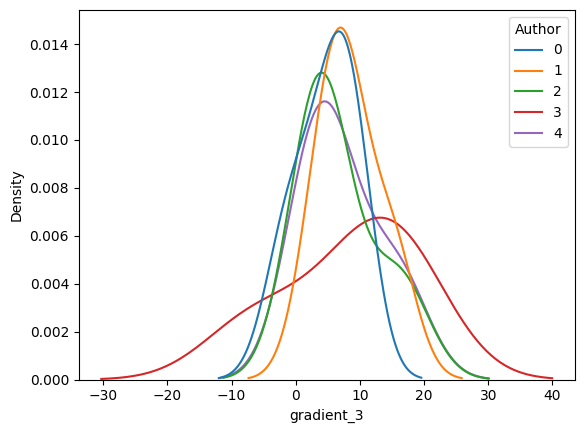

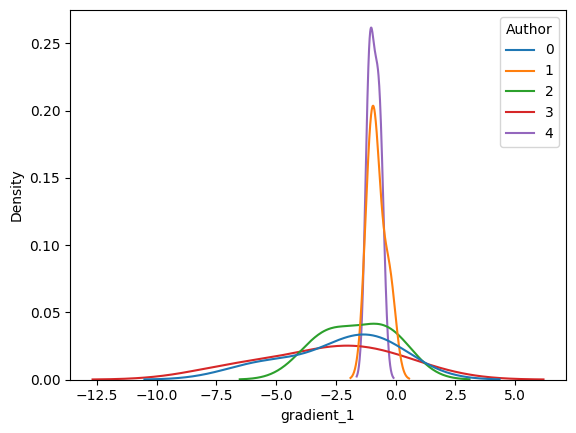

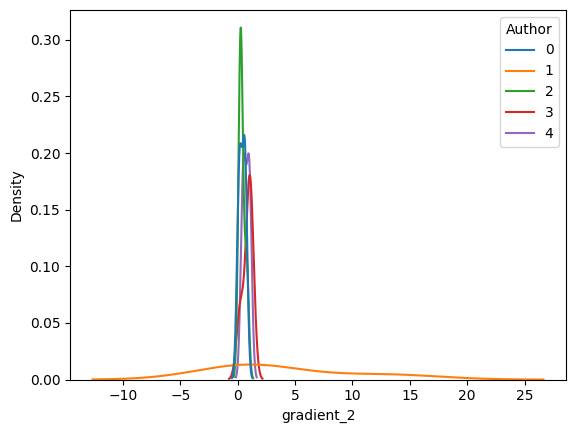

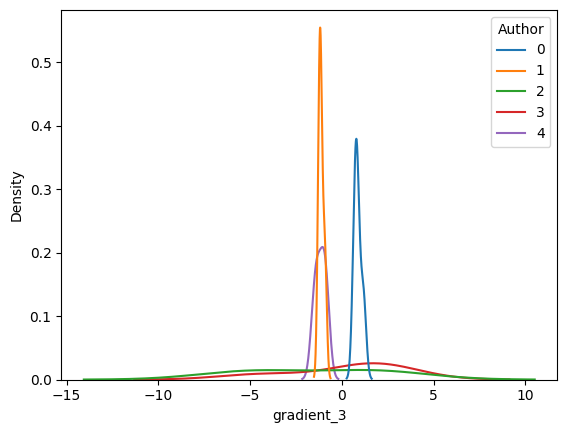

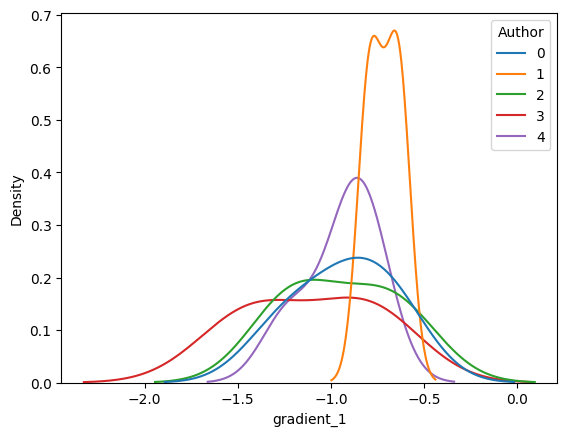

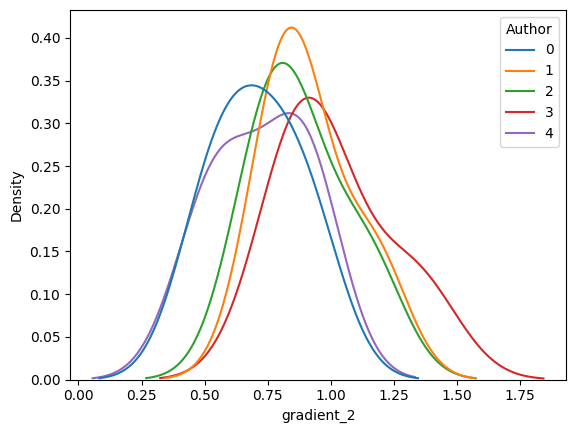

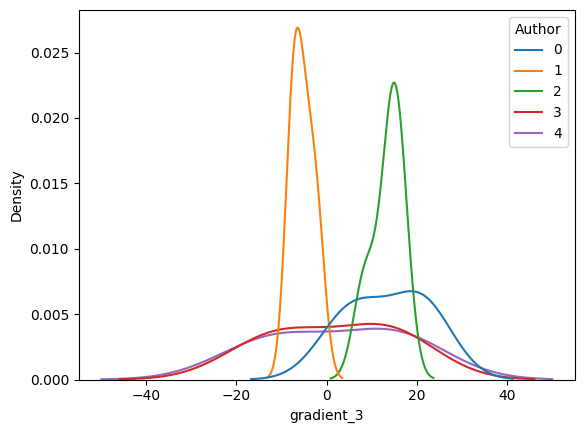

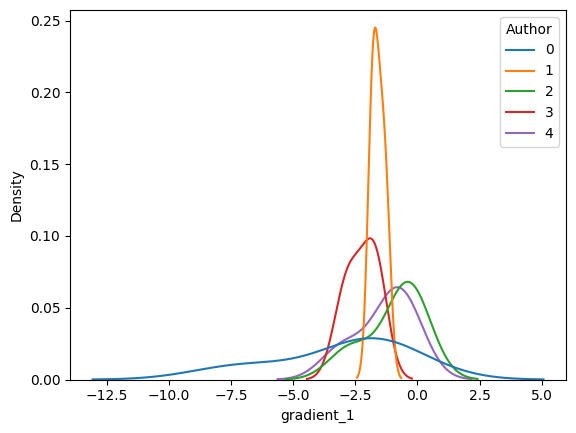

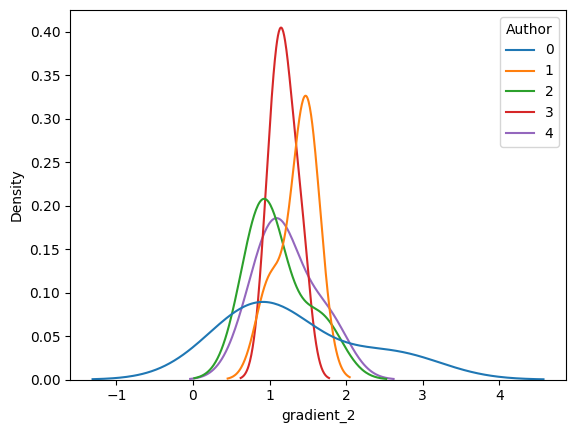

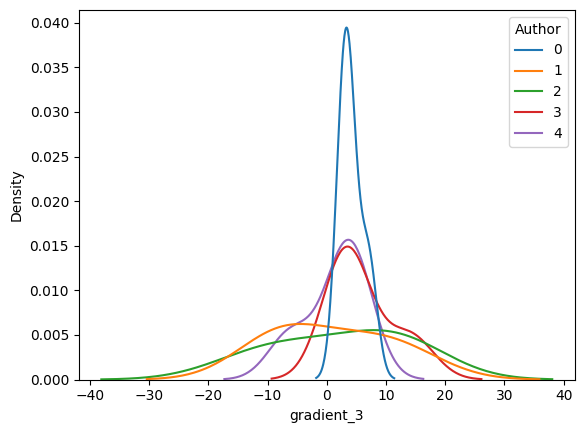

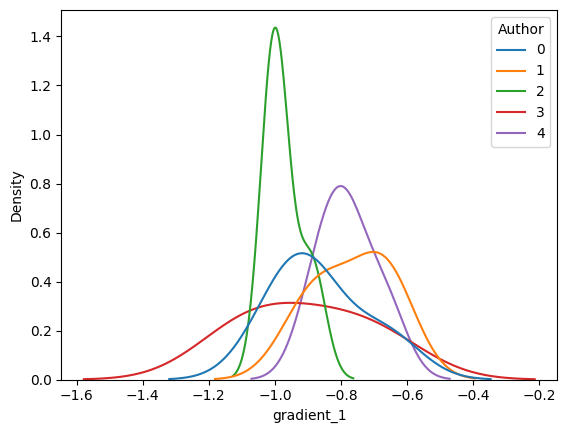

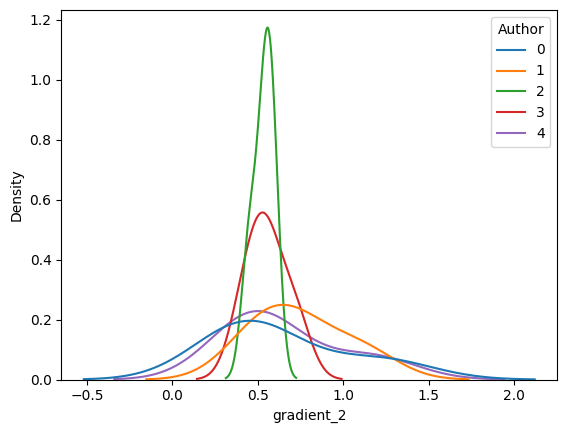

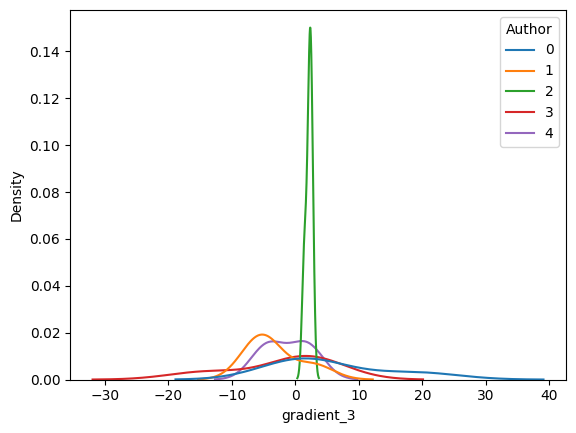

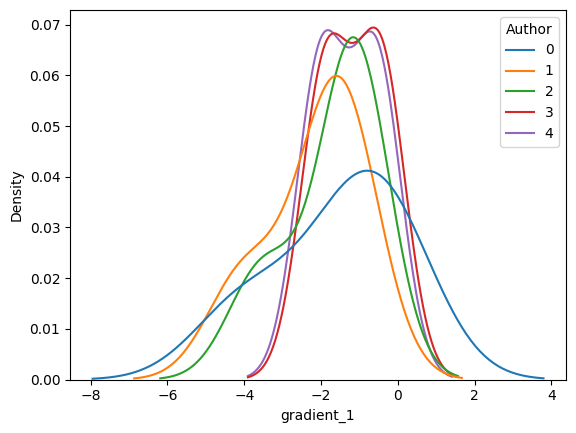

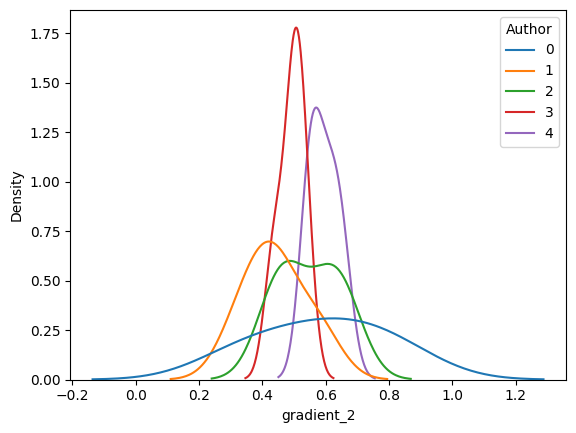

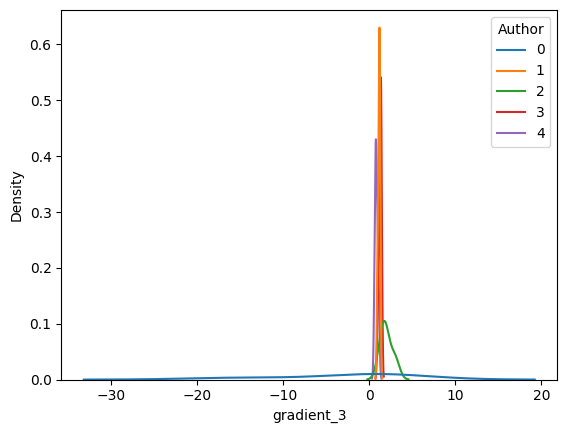

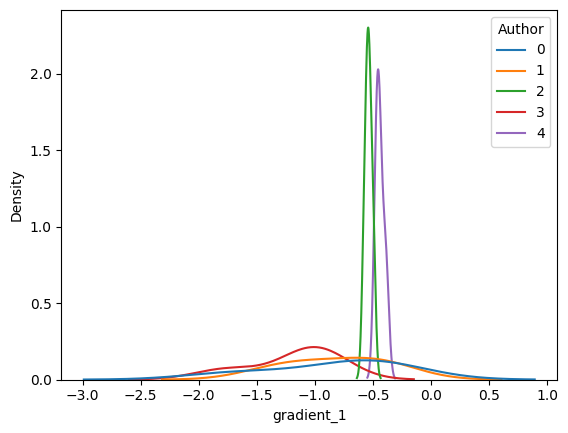

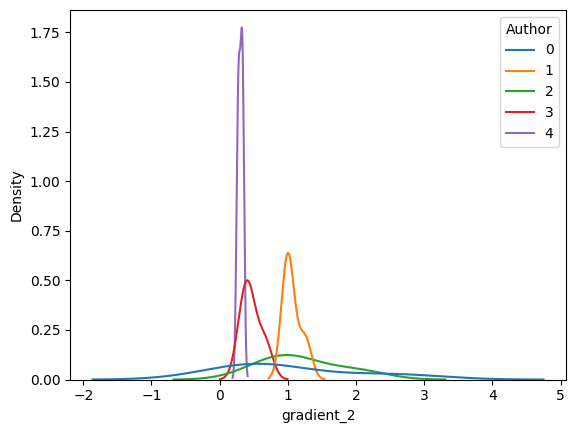

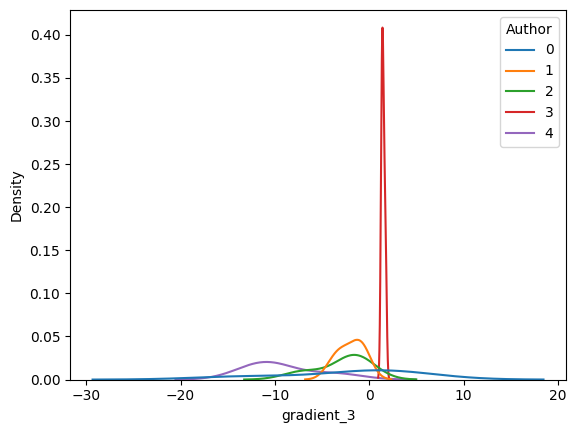

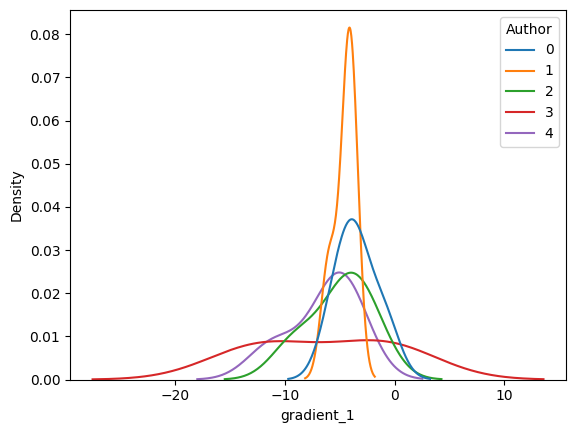

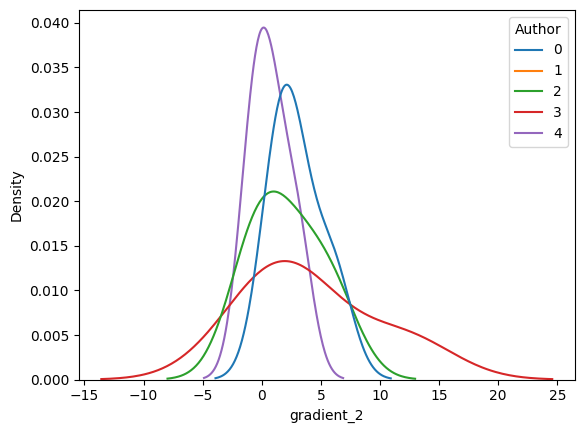

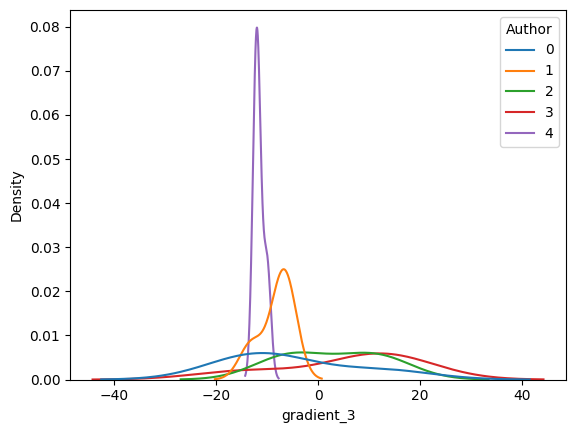

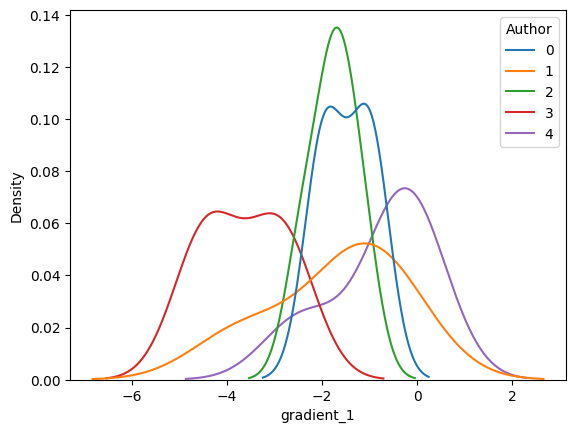

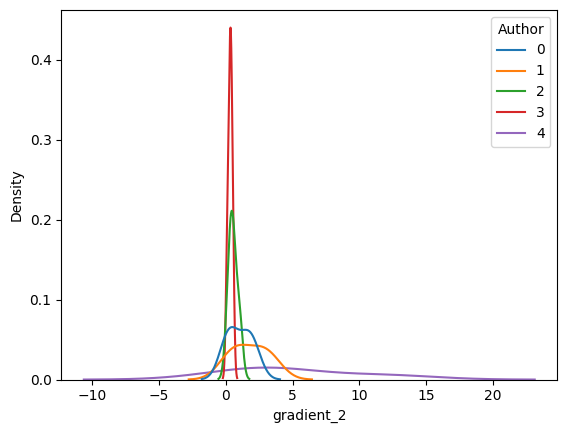

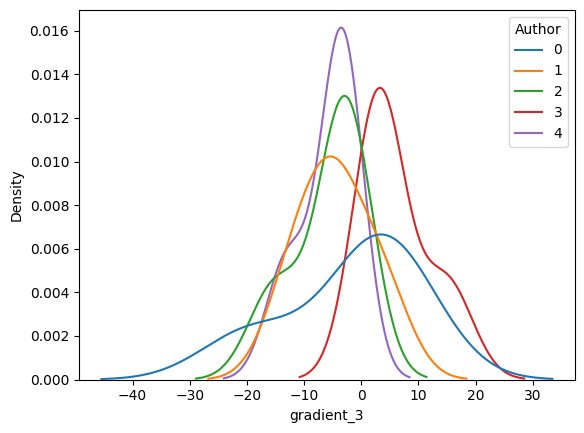

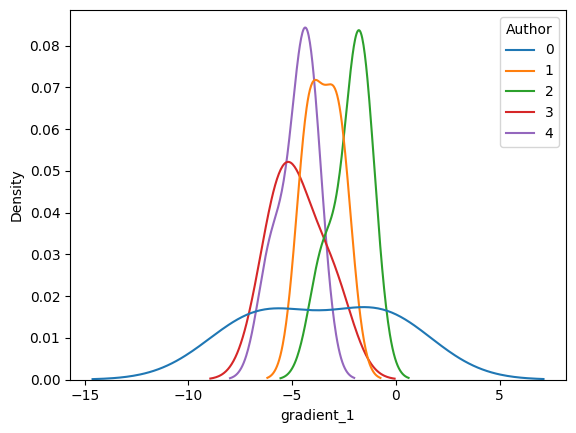

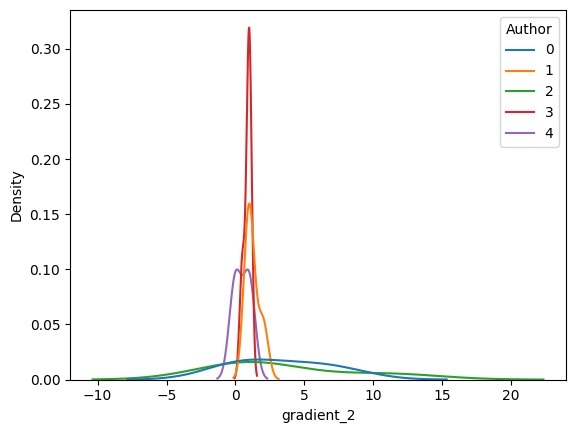

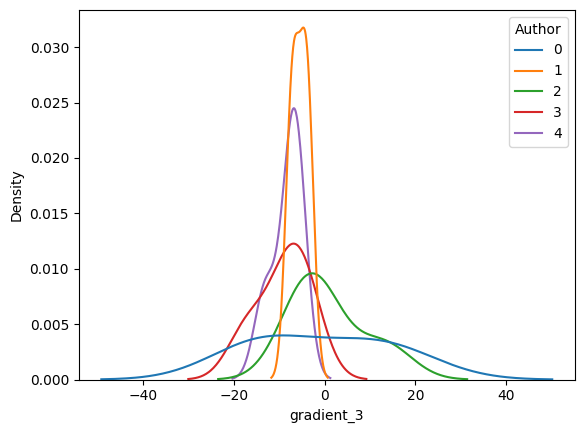

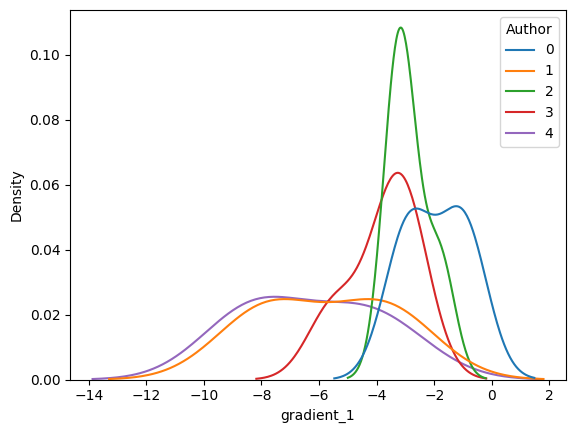

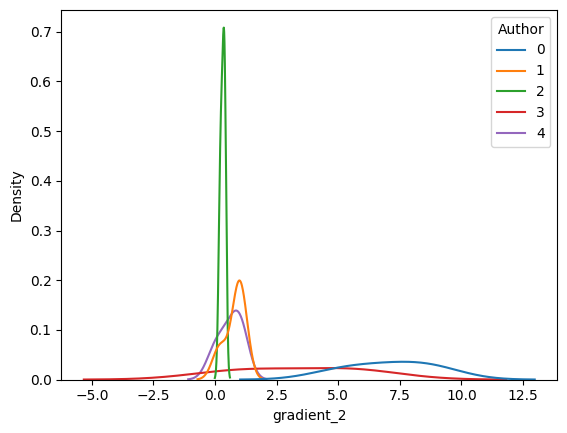

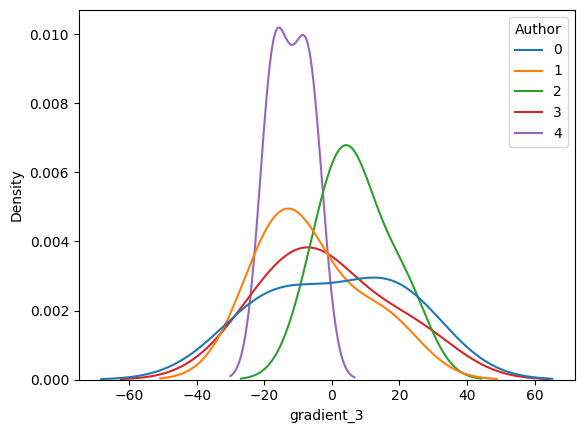

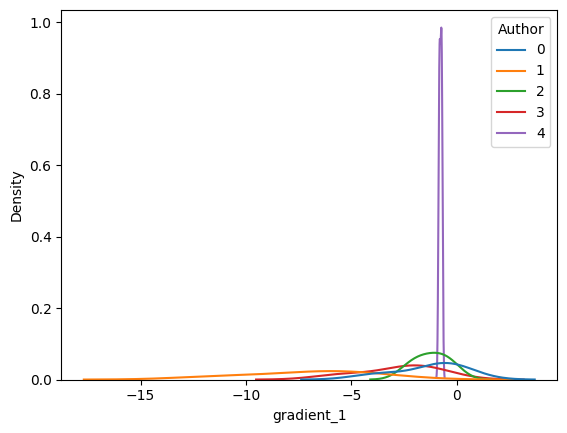

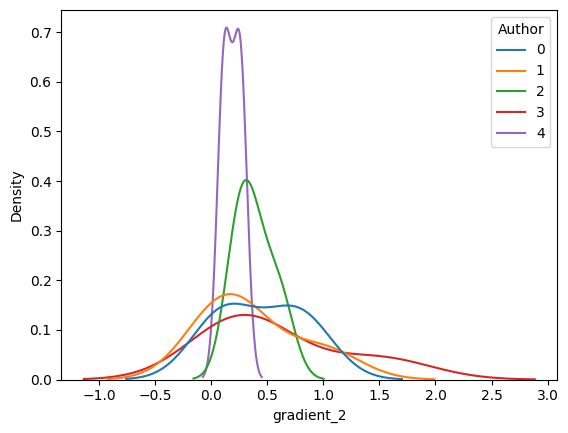

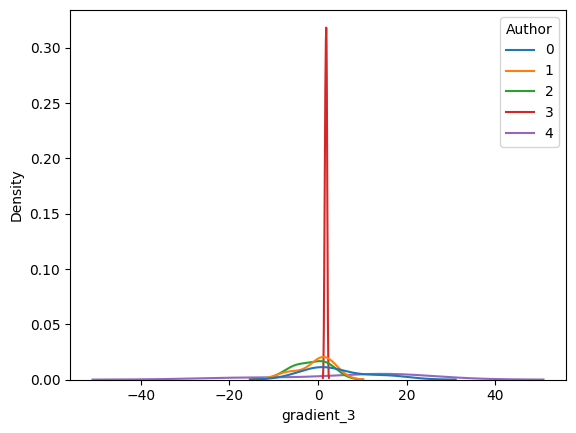

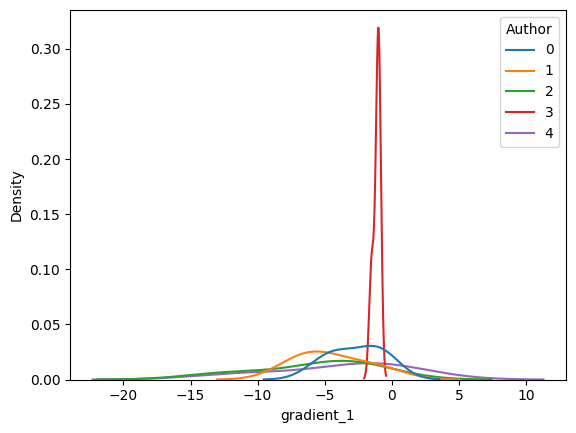

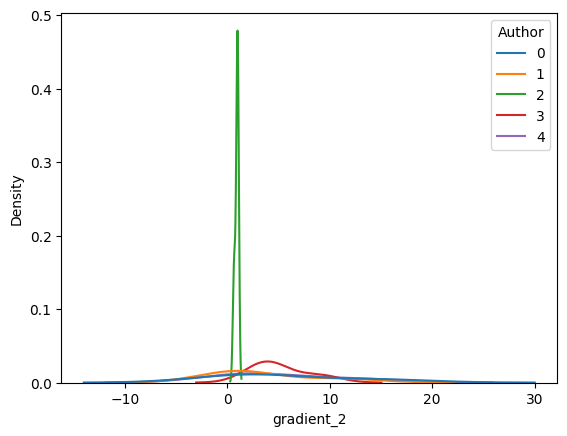

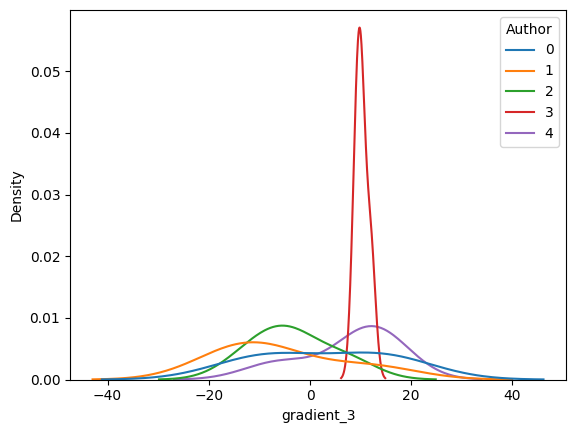

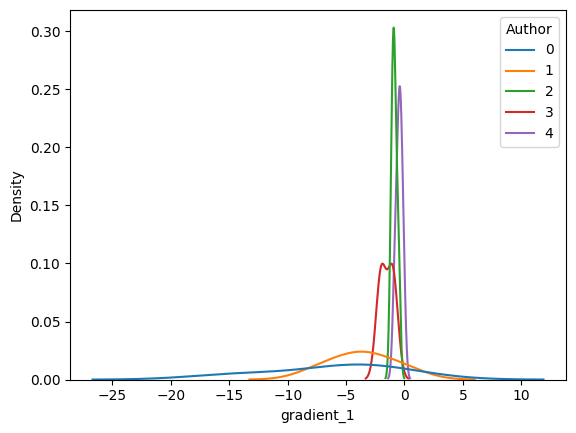

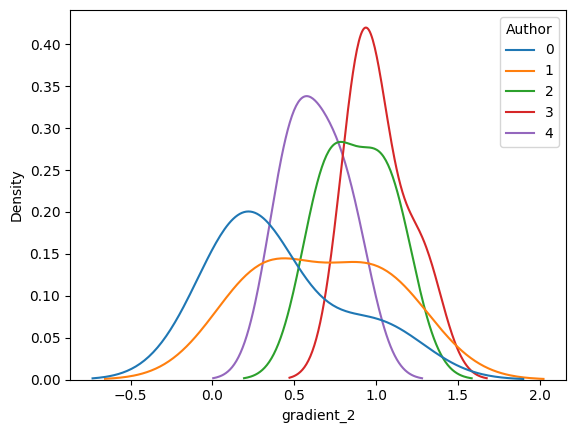

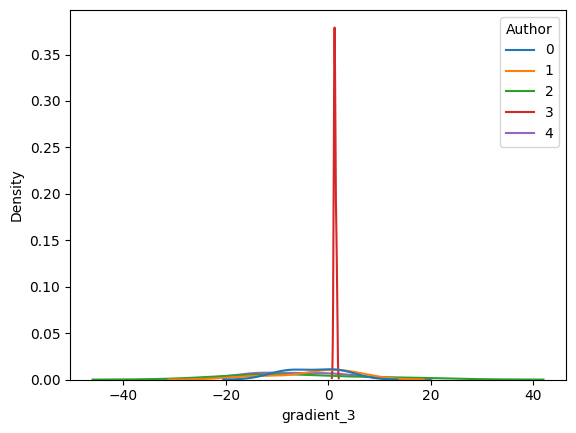

In [9]:
# def score(arr):

#     # print(arr)
#     arr = sorted(arr)
#     ranges = arr[-1] - arr[0]

#     return ranges, np.sqrt(sum([
#         (arr[1] - (arr[0] + ranges / 4)) ** 2,
#         (arr[2] - (arr[0] + ranges / 2)) ** 2,
#         (arr[3] - (arr[0] + 3 * ranges / 4)) ** 2,
#     ]))

log = {
    'character': [],
    'selected_gradient': [],
    'peaks': []
}

for char in unique_char:

    log['character'].append(char)
    char_data = gradient_data[gradient_data['Character'] == char][['Author', 'gradient_1', 'gradient_2', 'gradient_3']]

    gradient_peaks = []
    gradient_range = []

    for gradient in ['gradient_1', 'gradient_2', 'gradient_3']:

        # Reset plot
        plt.figure()

        ax = sns.kdeplot(data=char_data[[gradient, 'Author']], x=gradient, hue='Author')

        peaks = []

        if len(ax.lines) == 5:
            peaks.append(ax.lines[0].get_xdata()[np.argmax(ax.lines[0].get_ydata())])
            peaks.append(ax.lines[1].get_xdata()[np.argmax(ax.lines[1].get_ydata())])
            peaks.append(ax.lines[2].get_xdata()[np.argmax(ax.lines[2].get_ydata())])
            peaks.append(ax.lines[3].get_ydata()[np.argmax(ax.lines[3].get_ydata())])
            peaks.append(ax.lines[4].get_ydata()[np.argmax(ax.lines[4].get_ydata())])

        # Some points are all same for that author => no KDE line => peak set to the point itself
        else:
            lines = deque(ax.lines)
            for author in char_data['Author'].unique():
                if len(char_data[char_data['Author'] == author][gradient].unique()) == 1:
                    peaks.append(*char_data[char_data['Author'] == author][gradient].unique())
                else:
                    line = lines.popleft()
                    peaks.append(line.get_xdata()[np.argmax(line.get_ydata())])

        gradient_peaks.append(peaks)

        # ranges, scores = score(peaks)
        ranges = max(peaks) - min(peaks)

        gradient_range.append(ranges)

    log['selected_gradient'].append(f'gradient_{np.argmax(gradient_range) + 1}')
    log['peaks'].append(gradient_peaks[np.argmax(gradient_range)])

    print(char, gradient_peaks[np.argmax(gradient_range)])

In [72]:
log_df = pd.DataFrame(log)
log_df

character selected_gradient  \
0          0        gradient_3   
1          1        gradient_2   
2          2        gradient_3   
3          3        gradient_3   
4          4        gradient_3   
5          5        gradient_2   
6          6        gradient_3   
7          7        gradient_3   
8          8        gradient_3   
9          9        gradient_3   
10         A        gradient_3   
11         B        gradient_3   
12         C        gradient_3   
13         D        gradient_3   
14         E        gradient_3   
15         F        gradient_3   
16         G        gradient_3   
17         H        gradient_3   
18         I        gradient_3   
19         J        gradient_3   
20         K        gradient_1   
21         L        gradient_3   
22         M        gradient_3   
23         N        gradient_3   
24         O        gradient_3   
25         P        gradient_3   
26         Q        gradient_3   
27         R        gradient_1   
28         S        gradient_3   
29         T        gradient_3   
30         U        gradient_3   
31         V        gradient_3   
32         W        gradient_3   
33         X        gradient_3   
34         Y        gradient_3   
35         Z        gradient_3   

                                                peaks  
0   [2.1708868008178115, 4.375198503470909, 15.686...  
1   [0.8901946727758834, 0.21280903160149223, 0.18...  
2   [6.1841375514031185, 1.477813746742025, 1.7745...  
3   [-5.78592497303347, 1.0287257920007458, -4.093...  
4   [14.722533808792633, 1.5538305922317788, -6.70...  
5   [4.960682786738627, 2.1979707059002327, 0.2184...  
6   [4.875184321334453, 3.3338838117341245, 4.4115...  
7   [2.98313322964062, 9.609532012281477, -5.08782...  
8   [0.09503830777130595, -9.275299004457263, -0.6...  
9   [-4.611957153872595, 0.6232887211489873, -3.36...  
10  [-4.566081387260809, -2.7367120698854244, 15.7...  
11  [1.6452240520186723, -6.0142380127267785, -1.5...  
12  [3.2272528125540836, 5.274350898377989, 5.4455...  
13  [-3.325060856197723, 4.463155171502652, -3.035...  
14  [2.0510842706839862, -4.59732770427264, 1.2856...  
15  [-1.2734943931741727, 2.240854156412806, 2.281...  
16  [8.429623942094885, 17.523726701489856, -6.998...  
17  [-1.1714036103886296, 1.0765429389747196, 1.84...  
18  [-6.949038697431618, 0.37936038288973606, 1.22...  
19  [-0.8949334493868446, -2.8997743717838063, 0.8...  
20  [-0.16730625249779507, -0.7734458733959162, -0...  
21  [2.0152905674164217, 1.0359492131733687, -14.4...  
22  [4.429894808016906, 13.131076760610014, 4.0528...  
23  [-1.0651941521199149, 1.7288336264215118, 0.87...  
24  [10.788315286017436, 9.930335650637424, 14.935...  
25  [3.634672718774599, 3.5050326000901197, 7.8438...  
26  [0.9655603534769686, 1.5246739387620707, 2.327...  
27  [-1.8238237570793716, -0.6276780846113281, -1....  
28  [-10.834553943180147, 1.4044188294304543, -1.6...  
29  [-11.970557367518444, 12.211601185429387, -3.2...  
30  [-3.474826286569076, 3.2502672687921166, -2.97...  
31  [-6.737544991121245, -6.753084357013801, -2.75...  
32  [-15.628159365147589, -6.970659311047811, 4.19...  
33  [14.07538983352353, 1.8556029096763362, 0.3712...  
34  [12.198556056977445, 9.776843591429186, -5.385...  
35  [-11.383422472172509, 1.23188387889317, -10.18...

### Fuzzy Logic System Testing

In [37]:
manual = pd.read_csv('./HandwrittingAuthorIdentifier/manual_rules.csv')
manual

character  has_2_gradient  selected_gradient_1  selected_gradient_2  \
0          0               0                    2                  NaN   
1          1               1                    2                  3.0   
2          2               0                    2                  NaN   
3          3               0                    3                  NaN   
4          4               0                    3                  NaN   
5          5               0                    2                  NaN   
6          6               0                    2                  NaN   
7          7               0                    1                  NaN   
8          8               0                    2                  NaN   
9          9               0                    2                  NaN   
10         A               0                    2                  NaN   
11         B               0                    2                  NaN   
12         C               0                    2                  NaN   
13         D               0                    2                  NaN   
14         E               0                    2                  NaN   
15         F               0                    2                  NaN   
16         G               1                    2                  1.0   
17         H               0                    2                  NaN   
18         I               0                    2                  NaN   
19         J               0                    2                  NaN   
20         K               0                    2                  NaN   
21         L               0                    1                  NaN   
22         M               0                    2                  NaN   
23         N               0                    2                  NaN   
24         O               0                    2                  NaN   
25         P               0                    1                  NaN   
26         Q               0                    1                  NaN   
27         R               0                    1                  NaN   
28         S               0                    1                  NaN   
29         T               0                    1                  NaN   
30         U               0                    1                  NaN   
31         V               0                    1                  NaN   
32         W               0                    1                  NaN   
33         X               0                    1                  NaN   
34         Y               0                    1                  NaN   
35         Z               0                    2                  NaN   

     mf0_1  mf0_1_end   mf1_1  mf1_1_end  mf2_1  mf2_1_end  ...  causes_0  \
0    0.249      0.616   0.332      0.667  0.500      0.600  ...         1   
1    0.099      0.167   0.132      0.231  0.049      1.001  ...         0   
2   -5.001     -0.999  -1.501     -0.857 -1.501     -0.352  ...         2   
3  -11.001     -2.999  -4.501     -1.333 -3.001     -0.666  ...         3   
4  -14.001     -7.499  -8.501     -5.999 -6.001     -3.249  ...         0   
5    0.153      0.438  -1.001      0.751  0.110      2.001  ...         0   
6    0.266      0.287   0.076      0.501  0.363      0.584  ...         2   
7  -10.001     -2.499  -5.501     -2.499 -4.667     -0.999  ...         1   
8    0.157      0.467   0.357      0.501  0.249      0.751  ...         0   
9    0.095      0.305   0.221      0.801  0.999      1.251  ...         0   
10   0.227      0.389   0.315      0.401  0.333      0.667  ...         1   
11   0.428      0.715   0.615      1.286  0.461      1.501  ...         2   
12   0.301      0.333   0.199      0.467  0.210      0.467  ...         1   
13   0.833      1.000   0.875      1.556  0.888      1.000  ...         1   
14   0.105      0.375   0.437      0.750  0.157      0.942  ...         2   
15   0.222      0.625   0.250   

In [60]:
import random

def evaluate_fuzzy_model_manual(chosen_gradient_val_1, chosen_gradient_val_2, has_2_gradient, char):

    a_0, a_1, b_0, b_1, c_0, c_1, d_0, d_1, e_0, e_1 = manual[manual['character'] == char].iloc[:, 4:14].values[0]
    rank_1, rank_2, rank_3, rank_4, rank_5 = manual[manual['character'] == char].iloc[:, 24:29].values[0].astype(int)

    # Antecedent
    peaks = ctrl.Antecedent(np.arange(-28, 28.001, 0.001), f'peaks \'{char}\'')
    peaks['0'] = fuzz.trapmf(peaks.universe, [-28, -28, (a_0 + a_1) / 2, a_1])
    peaks['1'] = fuzz.trimf(peaks.universe, [b_0, (b_0 + b_1) / 2, b_1])
    peaks['2'] = fuzz.trimf(peaks.universe, [c_0, (c_0 + c_1) / 2, c_1])
    peaks['3'] = fuzz.trimf(peaks.universe, [d_0, (d_0 + d_1) / 2, d_1])
    peaks['4'] = fuzz.trapmf(peaks.universe, [e_0, (e_0 + e_1) / 2, 28, 28])

    # Consequent
    author = ctrl.Consequent(np.arange(0, 4.1, 0.1), 'author')
    author['0'] = fuzz.trimf(author.universe, [0, 0, 0.5])
    author['1'] = fuzz.trimf(author.universe, [0.5, 1, 1.5])
    author['2'] = fuzz.trimf(author.universe, [1.5, 2, 2.5])
    author['3'] = fuzz.trimf(author.universe, [2.5, 3, 3.5])
    author['4'] = fuzz.trimf(author.universe, [3.5, 4, 4])

    rules = []

    if has_2_gradient:

        a_2, a_3, b_2, b_3, c_2, c_3, d_2, d_3, e_2, e_3 = manual[manual['character'] == char].iloc[:, 4:14].values[0]
        peaks_2 = ctrl.Antecedent(np.arange(-28, 28.01, 0.01), f'peaks_2 \'{char}\'')
        peaks_2['0'] = fuzz.trapmf(peaks_2.universe, [-28, -28, (a_2 + a_3) / 2, a_3])
        peaks_2['1'] = fuzz.trimf(peaks_2.universe, [b_2, (b_2 + b_3) / 2, b_3])
        peaks_2['2'] = fuzz.trimf(peaks_2.universe, [c_2, (c_2 + c_3) / 2, c_3])
        peaks_2['3'] = fuzz.trimf(peaks_2.universe, [d_2, (d_2 + d_3) / 2, d_3])
        peaks_2['4'] = fuzz.trapmf(peaks_2.universe, [e_2, (e_2 + e_3) / 2, 28, 28])

        # Rule
        rank_6, rank_7, rank_8, rank_9, rank_10 = manual[manual['character'] == char].iloc[:, 24:29].values[0].astype(int)
        rules = [
            ctrl.Rule(peaks[f'{rank_1}'] & peaks_2[f'{rank_6}'], author['0']),
            ctrl.Rule(peaks[f'{rank_2}'] & peaks_2[f'{rank_7}'], author['1']),
            ctrl.Rule(peaks[f'{rank_3}'] & peaks_2[f'{rank_8}'], author['2']),
            ctrl.Rule(peaks[f'{rank_4}'] & peaks_2[f'{rank_9}'], author['3']),
            ctrl.Rule(peaks[f'{rank_5}'] & peaks_2[f'{rank_10}'], author['4']),
        ]

    else:

        # Rule
        rules = [
            ctrl.Rule(peaks[f'{rank_1}'], author['0']),
            ctrl.Rule(peaks[f'{rank_2}'], author['1']),
            ctrl.Rule(peaks[f'{rank_3}'], author['2']),
            ctrl.Rule(peaks[f'{rank_4}'], author['3']),
            ctrl.Rule(peaks[f'{rank_5}'], author['4']),
        ]

    # Control System
    fuzzy_control_system = ctrl.ControlSystem(rules)

    # Simulation
    fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_control_system)

    # Prediction
    try:
        fuzzy_simulator.input[f'peaks \'{char}\''] = chosen_gradient_val_1
        if has_2_gradient: fuzzy_simulator.input[f'peaks_2 \'{char}\''] = chosen_gradient_val_2

        fuzzy_simulator.compute()
    except:
        return random.random() * 5

    return fuzzy_simulator.output['author']

result = {
    'prediction': [],
    'prediction2': [],
    'actual': gradient_data['Author'].astype(int).tolist()
}

for _, row in gradient_data.iterrows():

    char = row['Character']
    has_2_gradient = manual[manual['character'] == char]['has_2_gradient'].values[0] == 1

    chosen_gradient_val_1 = row[manual[manual['character'] == char]['selected_gradient_1'].values[0]]
    chosen_gradient_val_2 = None if not has_2_gradient else row[int(manual[manual['character'] == char]['selected_gradient_2'].values[0])]

    evaluated_result = evaluate_fuzzy_model_manual(chosen_gradient_val_1, chosen_gradient_val_2, has_2_gradient, char)

    result['prediction'] += [evaluated_result]
    result['prediction2'] += [round(evaluated_result)]

# View Prediction Result
result_df_manual = pd.DataFrame({
    'fuzzy_pred': result['prediction'],
    'fuzzy_pred_class': result['prediction2'],
    'actual_class': result['actual']
})

result_df_manual

fuzzy_pred  fuzzy_pred_class  actual_class
0      3.833333                 4             0
1      3.833333                 4             0
2      3.833333                 4             0
3      3.833333                 4             0
4      3.833333                 4             1
..          ...               ...           ...
715    3.000000                 3             3
716    3.833333                 4             4
717    3.833333                 4             4
718    3.000000                 3             4
719    3.833333                 4             4

[720 rows x 3 columns]

In [98]:
def evaluate_fuzzy_model(chosen_gradient_val, char):

    char_peaks = log_df[log_df['character'] == char]['peaks'].tolist()[0]
    a, b, c, d, e = sorted_char_peaks = sorted(char_peaks)
    rank_1, rank_2, rank_3, rank_4, rank_5 = [sorted_char_peaks.index(x) for x in char_peaks]

    # Antecedent
    peaks = ctrl.Antecedent(np.arange(-28, 28.01, 0.01), f'peaks \'{char}\'')
    peaks['0'] = fuzz.trapmf(peaks.universe, [-28, -28, a, b])
    peaks['1'] = fuzz.trimf(peaks.universe, [a, b, c])
    peaks['2'] = fuzz.trimf(peaks.universe, [b, c, d])
    peaks['3'] = fuzz.trimf(peaks.universe, [c, d, e])
    peaks['4'] = fuzz.trapmf(peaks.universe, [d, e, 28, 28])

    # Consequent
    author = ctrl.Consequent(np.arange(0, 4.1, 0.1), 'author')
    author['0'] = fuzz.trimf(author.universe, [0, 0, 0.5])
    author['1'] = fuzz.trimf(author.universe, [0.5, 1, 1.5])
    author['2'] = fuzz.trimf(author.universe, [1.5, 2, 2.5])
    author['3'] = fuzz.trimf(author.universe, [2.5, 3, 3.5])
    author['4'] = fuzz.trimf(author.universe, [3.5, 4, 4])

    # Rule
    rules = [
        ctrl.Rule(peaks[f'{rank_1}'], author['0']),
        ctrl.Rule(peaks[f'{rank_2}'], author['1']),
        ctrl.Rule(peaks[f'{rank_3}'], author['2']),
        ctrl.Rule(peaks[f'{rank_4}'], author['3']),
        ctrl.Rule(peaks[f'{rank_5}'], author['4']),
    ]

    # Control System
    fuzzy_control_system = ctrl.ControlSystem(rules)

    # Simulation
    fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_control_system)

    # Prediction
    fuzzy_simulator.input[f'peaks \'{char}\''] = chosen_gradient_val
    fuzzy_simulator.compute()

    return fuzzy_simulator.output['author']

result = {
    'prediction': [],
    'prediction2': [],
    'actual': gradient_data['Author'].astype(int).tolist()
}

for _, row in gradient_data.iterrows():

    char = row['Character']

    chosen_gradient_val = row[
        ['gradient_1', 'gradient_2', 'gradient_3'].index(
            log_df[log_df['character'] == char]['selected_gradient'].tolist()[0]
        )
    ]

    evaluated_result = evaluate_fuzzy_model(chosen_gradient_val, char)

    result['prediction'] += [evaluated_result]
    result['prediction2'] += [round(evaluated_result)]

# View Prediction Result
result_df = pd.DataFrame({
    'fuzzy_pred': result['prediction'],
    'fuzzy_pred_class': result['prediction2'],
    'actual_class': result['actual']
})

result_df

fuzzy_pred  fuzzy_pred_class  actual_class
0      3.000000                 3             0
1      3.000000                 3             0
2      3.000000                 3             0
3      3.000000                 3             0
4      3.000000                 3             1
..          ...               ...           ...
715    1.000000                 1             3
716    2.730021                 3             4
717    0.166667                 0             4
718    1.000000                 1             4
719    0.166667                 0             4

[720 rows x 3 columns]

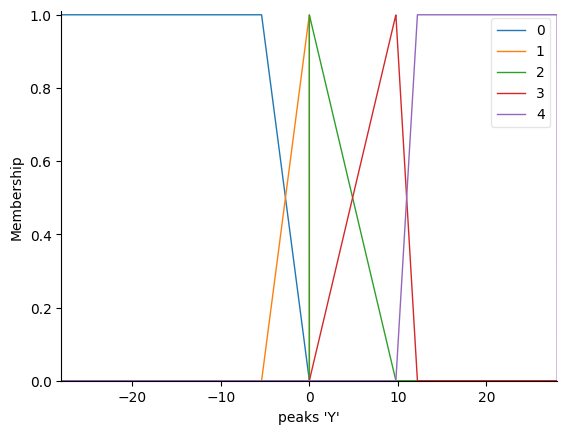

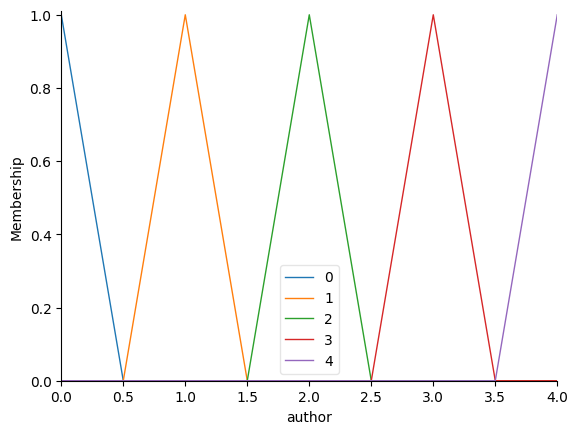

In [56]:
char = 'Y'

char_peaks = log_df[log_df['character'] == char]['peaks'].tolist()[0]
a, b, c, d, e = sorted_char_peaks = sorted(char_peaks)
rank_1, rank_2, rank_3, rank_4, rank_5 = [sorted_char_peaks.index(x) for x in char_peaks]

# Antecedent
peaks = ctrl.Antecedent(np.arange(-28, 28.01, 0.01), f'peaks \'{char}\'')
peaks['0'] = fuzz.trapmf(peaks.universe, [-28, -28, a, b])
peaks['1'] = fuzz.trimf(peaks.universe, [a, b, c])
peaks['2'] = fuzz.trimf(peaks.universe, [b, c, d])
peaks['3'] = fuzz.trimf(peaks.universe, [c, d, e])
peaks['4'] = fuzz.trapmf(peaks.universe, [d, e, 28, 28])

# Consequent
author = ctrl.Consequent(np.arange(0, 4.1, 0.1), 'author')
author['0'] = fuzz.trimf(author.universe, [0, 0, 0.5])
author['1'] = fuzz.trimf(author.universe, [0.5, 1, 1.5])
author['2'] = fuzz.trimf(author.universe, [1.5, 2, 2.5])
author['3'] = fuzz.trimf(author.universe, [2.5, 3, 3.5])
author['4'] = fuzz.trimf(author.universe, [3.5, 4, 4])

peaks.view()
author.view()

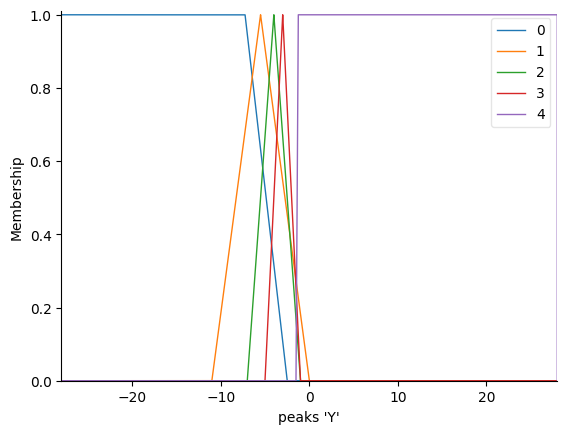

In [59]:
char = 'Y'

a_0, a_1, b_0, b_1, c_0, c_1, d_0, d_1, e_0, e_1 = manual[manual['character'] == char].iloc[:, 4:14].values[0]
rank_1, rank_2, rank_3, rank_4, rank_5 = manual[manual['character'] == char].iloc[:, 24:29].values[0].astype(int)

# Antecedent
peaks = ctrl.Antecedent(np.arange(-28, 28.001, 0.001), f'peaks \'{char}\'')
peaks['0'] = fuzz.trapmf(peaks.universe, [-28, -28, (a_0 + a_1) / 2, a_1])
peaks['1'] = fuzz.trimf(peaks.universe, [b_0, (b_0 + b_1) / 2, b_1])
peaks['2'] = fuzz.trimf(peaks.universe, [c_0, (c_0 + c_1) / 2, c_1])
peaks['3'] = fuzz.trimf(peaks.universe, [d_0, (d_0 + d_1) / 2, d_1])
peaks['4'] = fuzz.trapmf(peaks.universe, [e_0, (e_0 + e_1) / 2, 28, 28])

peaks.view()

In [102]:
# Measure Prediction Metrics
rmse = np.sqrt(mean_squared_error(result['actual'], result['prediction']))
acc = accuracy_score(result['actual'], result['prediction2'])

print(f'rmse: {rmse}, accuracy: {acc}')

# Auto -> 0.23194444444444445
# Manual -> 0.19722222222222222

rmse: 1.926825671531077, accuracy: 0.23194444444444445


In [100]:
char_digit_acc = result_df.copy()
char_digit_acc['character'] = gradient_data['Character']
char_digit_acc['accurate'] = char_digit_acc['fuzzy_pred_class'] == char_digit_acc['actual_class']
char_digit_acc = char_digit_acc.groupby(['character'])['accurate'].sum().reset_index()
char_digit_acc['accuracy'] = char_digit_acc['accurate'] / 20
char_digit_acc.sort_values(by='accuracy', ascending=False)

character  accurate  accuracy
19         J         8      0.40
16         G         7      0.35
0          0         6      0.30
14         E         6      0.30
34         Y         6      0.30
32         W         6      0.30
29         T         6      0.30
33         X         5      0.25
27         R         5      0.25
26         Q         5      0.25
24         O         5      0.25
21         L         5      0.25
17         H         5      0.25
18         I         5      0.25
13         D         5      0.25
7          7         5      0.25
12         C         5      0.25
11         B         5      0.25
2          2         5      0.25
4          4         5      0.25
6          6         5      0.25
31         V         4      0.20
30         U         4      0.20
5          5         4      0.20
28         S         4      0.20
25         P         4      0.20
15         F         4      0.20
8          8         4      0.20
22         M         4      0.20
10         A         4      0.20
1          1         4      0.20
35         Z         4      0.20
3          3         3      0.15
9          9         2      0.10
20         K         2      0.10
23         N         1      0.05

In [101]:
char_digit_acc = result_df.copy()
char_digit_acc['author'] = gradient_data['Author']
char_digit_acc['accurate'] = char_digit_acc['fuzzy_pred_class'] == char_digit_acc['actual_class']
char_digit_acc = char_digit_acc.groupby(['author'])['accurate'].sum().reset_index()
char_digit_acc['accuracy'] = char_digit_acc['accurate'] / 144
char_digit_acc.sort_values(by='accuracy', ascending=False)

author  accurate  accuracy
2      2        86  0.597222
1      1        42  0.291667
0      0        29  0.201389
4      4         6  0.041667
3      3         4  0.027778

In [99]:
char_digit_acc = result_df.copy()
char_digit_acc[char_digit_acc['fuzzy_pred_class'] == char_digit_acc['actual_class']]

fuzzy_pred  fuzzy_pred_class  actual_class
5      1.498184                 1             1
8      2.000000                 2             2
9      1.779889                 2             2
10     2.000000                 2             2
11     1.894354                 2             2
..          ...               ...           ...
691    2.410743                 2             2
705    1.000000                 1             1
706    1.136619                 1             1
710    2.286423                 2             2
711    2.237823                 2             2

[167 rows x 3 columns]

## Make Predictions

In [93]:
# Prediction pipeline
def neural_network_prediction(image_pixel_arr, use_best_model=True) -> str:

    if use_best_model: model = tf.keras.models.load_model('./HandwrittingAuthorIdentifier/ModelFile/best_model.h5')
    else: model = tf.keras.models.load_model('not_so_best_model.h5')

    predicted_val = model.predict(image_pixel_arr.reshape(1, 28, 28, 1)).argmax()

    return chr(predicted_val + 55) if predicted_val >= 10 else str(predicted_val)

In [64]:
# neural_network_prediction('./HandwrittingAuthorIdentifier/Dataset/Author1/E4.png')

In [96]:
def fuzzy_logic_prediction(image_pixel_arr, char, use_auto_fuzzy_rules=True):

    # Force use auto
    use_auto_fuzzy_rules = True

    image_series = pd.Series(image_pixel_arr.flatten(), index=pixel_columns, name='brightness')
    gradient_tuple = get_gradient(image_series)
    chosen_gradient_val = gradient_tuple[
        ['gradient_1', 'gradient_2', 'gradient_3'].index(
            log_df[log_df['character'] == char]['selected_gradient'].tolist()[0]
        )
    ]

    if use_auto_fuzzy_rules:

        char_peaks = log_df[log_df['character'] == char]['peaks'].tolist()[0]
        a, b, c, d, e = sorted_char_peaks = sorted(char_peaks)
        rank_1, rank_2, rank_3, rank_4, rank_5 = [sorted_char_peaks.index(x) for x in char_peaks]

        # Antecedent
        peaks = ctrl.Antecedent(np.arange(-28, 28.01, 0.01), f'peaks \'{char}\'')
        peaks['0'] = fuzz.trapmf(peaks.universe, [-28, -28, a, b])
        peaks['1'] = fuzz.trimf(peaks.universe, [a, b, c])
        peaks['2'] = fuzz.trimf(peaks.universe, [b, c, d])
        peaks['3'] = fuzz.trimf(peaks.universe, [c, d, e])
        peaks['4'] = fuzz.trapmf(peaks.universe, [d, e, 28, 28])

    else:
        pass

    # Consequent
    AUTHORS = ['Jun Yi', 'Zheng Qian', 'Kenneth', 'Boon Guan', 'Zi Xiang']
    author = ctrl.Consequent(np.arange(0, 4.1, 0.1), 'author')
    author['0'] = fuzz.trimf(author.universe, [0, 0, 0.5])
    author['1'] = fuzz.trimf(author.universe, [0.5, 1, 1.5])
    author['2'] = fuzz.trimf(author.universe, [1.5, 2, 3.5])
    author['3'] = fuzz.trimf(author.universe, [2.5, 3, 4.5])
    author['4'] = fuzz.trimf(author.universe, [3.5, 4, 4])

    # Rule
    rules = []

    if use_auto_fuzzy_rules:
        rules = [
            ctrl.Rule(peaks[f'{rank_1}'], author['0']),
            ctrl.Rule(peaks[f'{rank_2}'], author['1']),
            ctrl.Rule(peaks[f'{rank_3}'], author['2']),
            ctrl.Rule(peaks[f'{rank_4}'], author['3']),
            ctrl.Rule(peaks[f'{rank_5}'], author['4']),
        ]
    else:
        pass

    # Control System
    fuzzy_control_system = ctrl.ControlSystem(rules)

    # Simulation
    fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_control_system)

    # Prediction
    fuzzy_simulator.input[f'peaks \'{char}\''] = chosen_gradient_val
    fuzzy_simulator.compute()

    return AUTHORS[round(fuzzy_simulator.output['author'])]

In [66]:
# fuzzy_logic_prediction(img_pixel, char='7')

In [67]:
def FINAL_PREDICT(image_path, use_best_model=True, use_auto_fuzzy_rules=True, return_char_pred=False) -> str:

    # Process Image
    image_pixel_arr = process_image(image_path)

    # Identify Character
    char_pred = neural_network_prediction(image_pixel_arr=image_pixel_arr, use_best_model=use_best_model)

    # Identify Author
    author_pred = fuzzy_logic_prediction(image_pixel_arr=image_pixel_arr, char=char_pred, use_auto_fuzzy_rules=use_auto_fuzzy_rules)

    if return_char_pred: return author_pred, char_pred
    return author_pred

In [216]:
FINAL_PREDICT('./HandwrittingAuthorIdentifier/Dataset/Author1/E4.png')

1/1 [==============================] - 0s 150ms/step


'Jun Yi'

In [97]:
test_images = [
    './HandwrittingAuthorIdentifier/Dataset/Author1/E4.png',
    './HandwrittingAuthorIdentifier/Dataset/Author1/A2.png',
    './HandwrittingAuthorIdentifier/Dataset/Author1/71.png',
    './HandwrittingAuthorIdentifier/Dataset/Author1/93.png',
    './HandwrittingAuthorIdentifier/Dataset/Author1/G3.png',
    './HandwrittingAuthorIdentifier/Dataset/Author2/E4.png',
    './HandwrittingAuthorIdentifier/Dataset/Author2/A2.png',
    './HandwrittingAuthorIdentifier/Dataset/Author2/71.png',
    './HandwrittingAuthorIdentifier/Dataset/Author2/93.png',
    './HandwrittingAuthorIdentifier/Dataset/Author2/G3.png',
    './HandwrittingAuthorIdentifier/Dataset/Author3/E4.png',
    './HandwrittingAuthorIdentifier/Dataset/Author3/A2.png',
    './HandwrittingAuthorIdentifier/Dataset/Author3/71.png',
    './HandwrittingAuthorIdentifier/Dataset/Author3/93.png',
    './HandwrittingAuthorIdentifier/Dataset/Author3/G3.png',
    './HandwrittingAuthorIdentifier/Dataset/Author4/E4.png',
    './HandwrittingAuthorIdentifier/Dataset/Author4/A2.png',
    './HandwrittingAuthorIdentifier/Dataset/Author4/71.png',
    './HandwrittingAuthorIdentifier/Dataset/Author4/93.png',
    './HandwrittingAuthorIdentifier/Dataset/Author4/G3.png',
    './HandwrittingAuthorIdentifier/Dataset/Author5/E4.png',
    './HandwrittingAuthorIdentifier/Dataset/Author5/A2.png',
    './HandwrittingAuthorIdentifier/Dataset/Author5/71.png',
    './HandwrittingAuthorIdentifier/Dataset/Author5/93.png',
    './HandwrittingAuthorIdentifier/Dataset/Author5/G3.png',
]

test_labels = [
    'Jun Yi',
    'Jun Yi',
    'Jun Yi',
    'Jun Yi',
    'Jun Yi',
    'Zheng Qian',
    'Zheng Qian',
    'Zheng Qian',
    'Zheng Qian',
    'Zheng Qian',
    'Kenneth',
    'Kenneth',
    'Kenneth',
    'Kenneth',
    'Kenneth',
    'Boon Guan',
    'Boon Guan',
    'Boon Guan',
    'Boon Guan',
    'Boon Guan',
    'Zi Xiang',
    'Zi Xiang',
    'Zi Xiang',
    'Zi Xiang',
    'Zi Xiang',
]

accurate_sum = 0

for test_image, y in zip(test_images, test_labels):

    y_pred = FINAL_PREDICT(test_image)

    if y_pred == y: accurate_sum += 1

print(f'Accuracy: {accurate_sum / len(test_images)}')

1/1 [==============================] - 0s 128ms/step
Accuracy: 0.4


## Explainability

In [210]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

explanation = explainer.explain_instance(X_reshaped[0].reshape(1, 28, 28, 1),
                                         classifier_fn = model1.predict,
                                         top_labels=10, hide_color=0, num_samples=720,
                                         segmentation_fn=segmenter)

fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_reshaped[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y[0]))
    c_ax.axis('off')

ValueError: only 2D color images are supported